In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/gdrive/MyDrive/multilogue-net
% cd /content/drive/MyDrive/11-777 MMML/multilogue-net

/content/drive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net


In [ ]:
! pip install -r requirements.txt

In [13]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import argparse, time, pandas as pd, os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from model_nce import RegressionModelNCE_, MaskedMSELoss, BiModalAttention,CrossLingualNCELoss
from dataloader import MOSEIRegression_NCE

np.random.seed(393)
torch.cuda.device([0])

In [24]:
args = {
    "no_cuda": False,
    "lr": 1e-4,
    "l2": 1e-4,
    "rec_dropout": 0.1,
    "dropout": 0.25,
    "batch_size":64,
    "epochs":150,
    "log_dir": 'logs/moseas_regression_NCE_FR+ESTranslate'
}
os.makedirs(args["log_dir"], exist_ok = True)

In [25]:
# Run on either GPU or CPU
args["cuda"] = torch.cuda.is_available() and not args["no_cuda"]
if args["cuda"]:
    print('Running on GPU')
else:
    print('Running on CPU')
print("Tensorboard logs in " + args["log_dir"])

Running on GPU
Tensorboard logs in logs/moseas_regression_NCE_FR+ESTranslate


In [26]:
def get_train_valid_sampler(trainset, valid=0.1):
    size = len(trainset)
    idx = range(size)
    split = int(valid*size)
    return SubsetRandomSampler(idx[split:]), SubsetRandomSampler(idx[:split])

def get_MOSEI_loaders_NCE(path, batch_size=128, valid=0.1, num_workers=0, pin_memory=False, mode="french"):
    trainset = MOSEIRegression_NCE(path=path)
    train_sampler, valid_sampler = get_train_valid_sampler(trainset, valid)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    print(mode)
    testset = MOSEIRegression_NCE(path=path, train=False,mode=mode)
    print("testset.len: ",testset.len)
    test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=testset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, valid_loader, test_loader

In [44]:
def train_or_eval_model(model, MSEloss, NCEloss, dataloader, epoch, optimizer=None, train=False):    
    losses, preds, labels, masks = [], [], [], []
    assert not train or optimizer!=None
    if train:
        model.train()
    else:
        model.eval()
    for data in dataloader:
        if train:
            optimizer.zero_grad()
        textf1, textf2, visuf, acouf, qmask, umask, label = [d.cuda() for d in data] if cuda else data
        print(textf1.shape, textf2.shape)
        d = model(textf1, textf2, acouf, visuf, textf1, qmask, umask) 
        pred, hidden_a, hidden_v, hidden_t1, hidden_t2, hidden_at1, hidden_at2, hidden_vt1, hidden_vt2 = d['pred'], d['a'], d['v'], d['t1'], d['t2'], d['at1'], d['at2'], d['vt1'], d['vt2']
        labels_ = label.view(-1) 
        umask_ = umask.view(-1)

        mseloss = MSEloss(pred, labels_, umask_)
        nceloss = NCEloss(hidden_at1, hidden_at2, hidden_vt1, hidden_vt2)
        loss = mseloss+nceloss

        preds.append(pred.data.cpu().numpy())
        labels.append(labels_.data.cpu().numpy())
        masks.append(umask_.cpu().numpy())
        loss_detach = mseloss.item()*masks[-1].sum() + nceloss.detach().cpu().numpy()
        # print(mseloss.item()*masks[-1].sum())
        # print(nceloss.detach().cpu().numpy())
        losses.append(loss_detach)
        if train:
            loss.backward()
            optimizer.step()
    if preds!=[]:
        preds  = np.concatenate(preds)
        labels = np.concatenate(labels)
        masks  = np.concatenate(masks)
    else:
        return float('nan'), float('nan'), float('nan'), [], [], []
    avg_loss = round(np.sum(losses)/np.sum(masks),4)
    mae = round(mean_absolute_error(labels,preds,sample_weight=masks),4)
    pred_lab = pd.DataFrame(list(filter(lambda x: x[2]==1, zip(labels, preds, masks))))
    pear = round(pearsonr(pred_lab[0], pred_lab[1])[0], 4)
    return avg_loss, mae, pear, labels, preds, masks

In [45]:
def log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear):
    print("Train Loss - MOSEAS Regression: ", train_loss)
    print("Test Loss - MOSEAS Regression: ", test_loss)
    print("Train MAE - MOSEAS Regression: ", train_mae)
    print("Test MAE - MOSEAS Regression: ", test_mae)
    print("Train Pearson - MOSEAS Regression: ", train_pear)
    print("Test Pearson - MOSEAS Regression: ", test_pear)

    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    all_train_mae.append(train_mae)
    all_test_mae.append(test_mae)
    all_train_pear.append(train_pear)
    all_test_pear.append(test_pear)

In [28]:

batch_size = args["batch_size"]
# batch_size = 1
n_classes  = 6
cuda       = args["cuda"]
n_epochs   = args["epochs"]
# MOSEI
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 384, 35, 300
# MOSEAS
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
# MOSEAS_full
D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
D_g, D_p, D_e, D_h, D_a = 150, 150, 100, 100, 100

# train model

## train with cross-lingual NCE loss L(T|V), FR+Spanish translated data

In [46]:
# Instantiate model
model = RegressionModelNCE_(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss(visual=True, audio=False)

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)

train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

french
testset.len:  57


In [47]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"{args['log_dir']}/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/150 [00:00<?, ?it/s]

torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 1/150 [00:12<31:01, 12.50s/it]

Train Loss - MOSEAS Regression:  0.5945
Test Loss - MOSEAS Regression:  0.5089
Train MAE - MOSEAS Regression:  0.5811
Test MAE - MOSEAS Regression:  0.5485
Train Pearson - MOSEAS Regression:  -0.1089
Test Pearson - MOSEAS Regression:  -0.079
saving checkpoint for epoch 0
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|▏         | 2/150 [00:25<31:34, 12.80s/it]

Train Loss - MOSEAS Regression:  0.5258
Test Loss - MOSEAS Regression:  0.5075
Train MAE - MOSEAS Regression:  0.5611
Test MAE - MOSEAS Regression:  0.5646
Train Pearson - MOSEAS Regression:  -0.0541
Test Pearson - MOSEAS Regression:  -0.0688
saving checkpoint for epoch 1
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 3/150 [00:38<31:10, 12.72s/it]

Train Loss - MOSEAS Regression:  0.5143
Test Loss - MOSEAS Regression:  0.4975
Train MAE - MOSEAS Regression:  0.5589
Test MAE - MOSEAS Regression:  0.5566
Train Pearson - MOSEAS Regression:  -0.0096
Test Pearson - MOSEAS Regression:  -0.0488
saving checkpoint for epoch 2
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 4/150 [00:51<31:27, 12.93s/it]

Train Loss - MOSEAS Regression:  0.5081
Test Loss - MOSEAS Regression:  0.4872
Train MAE - MOSEAS Regression:  0.5514
Test MAE - MOSEAS Regression:  0.5387
Train Pearson - MOSEAS Regression:  -0.0104
Test Pearson - MOSEAS Regression:  -0.0104
saving checkpoint for epoch 3
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 5/150 [01:04<31:21, 12.98s/it]

Train Loss - MOSEAS Regression:  0.4984
Test Loss - MOSEAS Regression:  0.4851
Train MAE - MOSEAS Regression:  0.5419
Test MAE - MOSEAS Regression:  0.5345
Train Pearson - MOSEAS Regression:  0.0241
Test Pearson - MOSEAS Regression:  0.0441
saving checkpoint for epoch 4
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 6/150 [01:17<30:55, 12.89s/it]

Train Loss - MOSEAS Regression:  0.4989
Test Loss - MOSEAS Regression:  0.481
Train MAE - MOSEAS Regression:  0.5391
Test MAE - MOSEAS Regression:  0.5332
Train Pearson - MOSEAS Regression:  0.029
Test Pearson - MOSEAS Regression:  0.074
saving checkpoint for epoch 5
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▍         | 7/150 [01:29<30:31, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4948
Test Loss - MOSEAS Regression:  0.4769
Train MAE - MOSEAS Regression:  0.5366
Test MAE - MOSEAS Regression:  0.5331
Train Pearson - MOSEAS Regression:  0.0464
Test Pearson - MOSEAS Regression:  0.0922
saving checkpoint for epoch 6
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▌         | 8/150 [01:43<30:42, 12.97s/it]

Train Loss - MOSEAS Regression:  0.4887
Test Loss - MOSEAS Regression:  0.474
Train MAE - MOSEAS Regression:  0.5375
Test MAE - MOSEAS Regression:  0.5336
Train Pearson - MOSEAS Regression:  0.0621
Test Pearson - MOSEAS Regression:  0.1077
saving checkpoint for epoch 7
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 9/150 [01:56<30:52, 13.14s/it]

Train Loss - MOSEAS Regression:  0.4844
Test Loss - MOSEAS Regression:  0.472
Train MAE - MOSEAS Regression:  0.5327
Test MAE - MOSEAS Regression:  0.5336
Train Pearson - MOSEAS Regression:  0.0914
Test Pearson - MOSEAS Regression:  0.1218
saving checkpoint for epoch 8
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 10/150 [02:08<30:00, 12.86s/it]

Train Loss - MOSEAS Regression:  0.4768
Test Loss - MOSEAS Regression:  0.4704
Train MAE - MOSEAS Regression:  0.5314
Test MAE - MOSEAS Regression:  0.5328
Train Pearson - MOSEAS Regression:  0.1242
Test Pearson - MOSEAS Regression:  0.1354
saving checkpoint for epoch 9
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 11/150 [02:21<29:55, 12.92s/it]

Train Loss - MOSEAS Regression:  0.481
Test Loss - MOSEAS Regression:  0.4689
Train MAE - MOSEAS Regression:  0.5352
Test MAE - MOSEAS Regression:  0.5321
Train Pearson - MOSEAS Regression:  0.1032
Test Pearson - MOSEAS Regression:  0.1473
saving checkpoint for epoch 10
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 12/150 [02:34<29:24, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4722
Test Loss - MOSEAS Regression:  0.4682
Train MAE - MOSEAS Regression:  0.5268
Test MAE - MOSEAS Regression:  0.5307
Train Pearson - MOSEAS Regression:  0.1492
Test Pearson - MOSEAS Regression:  0.1587
saving checkpoint for epoch 11
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▊         | 13/150 [02:46<28:42, 12.57s/it]

Train Loss - MOSEAS Regression:  0.4757
Test Loss - MOSEAS Regression:  0.4668
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.5302
Train Pearson - MOSEAS Regression:  0.1341
Test Pearson - MOSEAS Regression:  0.1669
saving checkpoint for epoch 12
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 14/150 [02:59<29:00, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4755
Test Loss - MOSEAS Regression:  0.465
Train MAE - MOSEAS Regression:  0.5288
Test MAE - MOSEAS Regression:  0.5305
Train Pearson - MOSEAS Regression:  0.1342
Test Pearson - MOSEAS Regression:  0.1727
saving checkpoint for epoch 13
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 15/150 [03:13<29:10, 12.96s/it]

Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.4638
Train MAE - MOSEAS Regression:  0.5266
Test MAE - MOSEAS Regression:  0.5301
Train Pearson - MOSEAS Regression:  0.1668
Test Pearson - MOSEAS Regression:  0.1793
saving checkpoint for epoch 14
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 16/150 [03:26<29:30, 13.21s/it]

Train Loss - MOSEAS Regression:  0.4684
Test Loss - MOSEAS Regression:  0.4629
Train MAE - MOSEAS Regression:  0.5247
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.1694
Test Pearson - MOSEAS Regression:  0.186
saving checkpoint for epoch 15
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█▏        | 17/150 [03:39<29:09, 13.15s/it]

Train Loss - MOSEAS Regression:  0.467
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5239
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1738
Test Pearson - MOSEAS Regression:  0.191
saving checkpoint for epoch 16
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 18/150 [03:53<28:59, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4626
Test Loss - MOSEAS Regression:  0.4615
Train MAE - MOSEAS Regression:  0.5225
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.1981
Test Pearson - MOSEAS Regression:  0.1958
saving checkpoint for epoch 17
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 19/150 [04:06<28:39, 13.12s/it]

Train Loss - MOSEAS Regression:  0.4565
Test Loss - MOSEAS Regression:  0.4599
Train MAE - MOSEAS Regression:  0.5192
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.2248
Test Pearson - MOSEAS Regression:  0.1996
saving checkpoint for epoch 18
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 20/150 [04:19<28:48, 13.30s/it]

Train Loss - MOSEAS Regression:  0.4488
Test Loss - MOSEAS Regression:  0.459
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.2579
Test Pearson - MOSEAS Regression:  0.2032
saving checkpoint for epoch 19
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 21/150 [04:33<28:33, 13.28s/it]

Train Loss - MOSEAS Regression:  0.4561
Test Loss - MOSEAS Regression:  0.4585
Train MAE - MOSEAS Regression:  0.5167
Test MAE - MOSEAS Regression:  0.527
Train Pearson - MOSEAS Regression:  0.2267
Test Pearson - MOSEAS Regression:  0.2069
saving checkpoint for epoch 20
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▍        | 22/150 [04:45<27:38, 12.96s/it]

Train Loss - MOSEAS Regression:  0.4494
Test Loss - MOSEAS Regression:  0.4577
Train MAE - MOSEAS Regression:  0.5137
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.2554
Test Pearson - MOSEAS Regression:  0.2095
saving checkpoint for epoch 21
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▌        | 23/150 [04:57<27:14, 12.87s/it]

Train Loss - MOSEAS Regression:  0.4465
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.2671
Test Pearson - MOSEAS Regression:  0.212
saving checkpoint for epoch 22
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 24/150 [05:11<27:11, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4512
Test Loss - MOSEAS Regression:  0.4565
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5254
Train Pearson - MOSEAS Regression:  0.249
Test Pearson - MOSEAS Regression:  0.2166
saving checkpoint for epoch 23
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 25/150 [05:24<27:07, 13.02s/it]

Train Loss - MOSEAS Regression:  0.4456
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5102
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.27
Test Pearson - MOSEAS Regression:  0.2158
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 26/150 [05:37<27:13, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4431
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5134
Test MAE - MOSEAS Regression:  0.5272
Train Pearson - MOSEAS Regression:  0.2815
Test Pearson - MOSEAS Regression:  0.2203
saving checkpoint for epoch 25
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 27/150 [05:50<26:59, 13.16s/it]

Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.4547
Train MAE - MOSEAS Regression:  0.5075
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.2838
Test Pearson - MOSEAS Regression:  0.2256
saving checkpoint for epoch 26
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▊        | 28/150 [06:03<26:24, 12.99s/it]

Train Loss - MOSEAS Regression:  0.4388
Test Loss - MOSEAS Regression:  0.4543
Train MAE - MOSEAS Regression:  0.5046
Test MAE - MOSEAS Regression:  0.5232
Train Pearson - MOSEAS Regression:  0.3005
Test Pearson - MOSEAS Regression:  0.2289
saving checkpoint for epoch 27
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 29/150 [06:16<26:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4364
Test Loss - MOSEAS Regression:  0.4572
Train MAE - MOSEAS Regression:  0.505
Test MAE - MOSEAS Regression:  0.5294
Train Pearson - MOSEAS Regression:  0.3039
Test Pearson - MOSEAS Regression:  0.2255
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 30/150 [06:29<26:08, 13.07s/it]

Train Loss - MOSEAS Regression:  0.4344
Test Loss - MOSEAS Regression:  0.4534
Train MAE - MOSEAS Regression:  0.5072
Test MAE - MOSEAS Regression:  0.5256
Train Pearson - MOSEAS Regression:  0.3172
Test Pearson - MOSEAS Regression:  0.2332
saving checkpoint for epoch 29
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 31/150 [06:43<26:09, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4337
Test Loss - MOSEAS Regression:  0.4541
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3153
Test Pearson - MOSEAS Regression:  0.2395
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██▏       | 32/150 [06:55<25:36, 13.02s/it]

Train Loss - MOSEAS Regression:  0.4337
Test Loss - MOSEAS Regression:  0.4566
Train MAE - MOSEAS Regression:  0.5012
Test MAE - MOSEAS Regression:  0.5296
Train Pearson - MOSEAS Regression:  0.3158
Test Pearson - MOSEAS Regression:  0.2355
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 33/150 [07:08<25:09, 12.91s/it]

Train Loss - MOSEAS Regression:  0.4341
Test Loss - MOSEAS Regression:  0.4513
Train MAE - MOSEAS Regression:  0.5061
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.3189
Test Pearson - MOSEAS Regression:  0.2432
saving checkpoint for epoch 32
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 34/150 [07:21<24:42, 12.78s/it]

Train Loss - MOSEAS Regression:  0.4258
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.4976
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.3389
Test Pearson - MOSEAS Regression:  0.2501
saving checkpoint for epoch 33
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 35/150 [07:33<24:35, 12.83s/it]

Train Loss - MOSEAS Regression:  0.4246
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.347
Test Pearson - MOSEAS Regression:  0.2506
saving checkpoint for epoch 34
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 36/150 [07:46<24:23, 12.84s/it]

Train Loss - MOSEAS Regression:  0.4232
Test Loss - MOSEAS Regression:  0.452
Train MAE - MOSEAS Regression:  0.4989
Test MAE - MOSEAS Regression:  0.5258
Train Pearson - MOSEAS Regression:  0.3483
Test Pearson - MOSEAS Regression:  0.249
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▍       | 37/150 [07:59<24:08, 12.82s/it]

Train Loss - MOSEAS Regression:  0.4207
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4967
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.3549
Test Pearson - MOSEAS Regression:  0.2565
saving checkpoint for epoch 36
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▌       | 38/150 [08:13<24:20, 13.04s/it]

Train Loss - MOSEAS Regression:  0.4208
Test Loss - MOSEAS Regression:  0.4475
Train MAE - MOSEAS Regression:  0.4935
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.363
Test Pearson - MOSEAS Regression:  0.2575
saving checkpoint for epoch 37
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 39/150 [08:25<23:49, 12.88s/it]

Train Loss - MOSEAS Regression:  0.4201
Test Loss - MOSEAS Regression:  0.4523
Train MAE - MOSEAS Regression:  0.4986
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.3603
Test Pearson - MOSEAS Regression:  0.2549
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 40/150 [08:38<23:28, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4146
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4925
Test MAE - MOSEAS Regression:  0.519
Train Pearson - MOSEAS Regression:  0.3713
Test Pearson - MOSEAS Regression:  0.2618
saving checkpoint for epoch 39
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 41/150 [08:51<23:15, 12.80s/it]

Train Loss - MOSEAS Regression:  0.411
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.5229
Train Pearson - MOSEAS Regression:  0.383
Test Pearson - MOSEAS Regression:  0.2602
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 42/150 [09:04<23:17, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4111
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4929
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.3826
Test Pearson - MOSEAS Regression:  0.262
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▊       | 43/150 [09:17<22:57, 12.87s/it]

Train Loss - MOSEAS Regression:  0.4115
Test Loss - MOSEAS Regression:  0.4475
Train MAE - MOSEAS Regression:  0.4921
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.3799
Test Pearson - MOSEAS Regression:  0.2639
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 44/150 [09:29<22:28, 12.72s/it]

Train Loss - MOSEAS Regression:  0.4045
Test Loss - MOSEAS Regression:  0.4469
Train MAE - MOSEAS Regression:  0.4858
Test MAE - MOSEAS Regression:  0.5195
Train Pearson - MOSEAS Regression:  0.4005
Test Pearson - MOSEAS Regression:  0.2666
saving checkpoint for epoch 43
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 45/150 [09:41<21:56, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4065
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4888
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3939
Test Pearson - MOSEAS Regression:  0.2675
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 46/150 [09:54<22:10, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4028
Test Loss - MOSEAS Regression:  0.4462
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4031
Test Pearson - MOSEAS Regression:  0.2706
saving checkpoint for epoch 45
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███▏      | 47/150 [10:07<21:59, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4018
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4055
Test Pearson - MOSEAS Regression:  0.2691
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 48/150 [10:20<21:52, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3962
Test Loss - MOSEAS Regression:  0.4463
Train MAE - MOSEAS Regression:  0.4816
Test MAE - MOSEAS Regression:  0.5186
Train Pearson - MOSEAS Regression:  0.4222
Test Pearson - MOSEAS Regression:  0.2729
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 49/150 [10:33<21:29, 12.77s/it]

Train Loss - MOSEAS Regression:  0.401
Test Loss - MOSEAS Regression:  0.4517
Train MAE - MOSEAS Regression:  0.4836
Test MAE - MOSEAS Regression:  0.5248
Train Pearson - MOSEAS Regression:  0.4101
Test Pearson - MOSEAS Regression:  0.2665
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 50/150 [10:46<21:23, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3989
Test Loss - MOSEAS Regression:  0.4469
Train MAE - MOSEAS Regression:  0.4848
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4148
Test Pearson - MOSEAS Regression:  0.2747
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▍      | 51/150 [10:58<20:57, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3996
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4144
Test Pearson - MOSEAS Regression:  0.2742
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▍      | 52/150 [11:11<20:39, 12.65s/it]

Train Loss - MOSEAS Regression:  0.3921
Test Loss - MOSEAS Regression:  0.4473
Train MAE - MOSEAS Regression:  0.4799
Test MAE - MOSEAS Regression:  0.5204
Train Pearson - MOSEAS Regression:  0.4311
Test Pearson - MOSEAS Regression:  0.2778
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▌      | 53/150 [11:23<20:25, 12.64s/it]

Train Loss - MOSEAS Regression:  0.3921
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4777
Test MAE - MOSEAS Regression:  0.5236
Train Pearson - MOSEAS Regression:  0.4309
Test Pearson - MOSEAS Regression:  0.2763
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 54/150 [11:36<20:11, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3936
Test Loss - MOSEAS Regression:  0.4478
Train MAE - MOSEAS Regression:  0.4825
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.4258
Test Pearson - MOSEAS Regression:  0.2787
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 55/150 [11:48<19:47, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4509
Train MAE - MOSEAS Regression:  0.4801
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.2766
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 56/150 [12:01<19:35, 12.51s/it]

Train Loss - MOSEAS Regression:  0.3904
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4794
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2837
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([41, 36, 300]) torch.Size([41, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 57/150 [12:13<19:18, 12.46s/it]

Train Loss - MOSEAS Regression:  0.3839
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4751
Test MAE - MOSEAS Regression:  0.5216
Train Pearson - MOSEAS Regression:  0.4502
Test Pearson - MOSEAS Regression:  0.2858
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▊      | 58/150 [12:26<19:27, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3841
Test Loss - MOSEAS Regression:  0.4515
Train MAE - MOSEAS Regression:  0.4739
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.4501
Test Pearson - MOSEAS Regression:  0.2851
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 59/150 [12:38<18:53, 12.46s/it]

Train Loss - MOSEAS Regression:  0.387
Test Loss - MOSEAS Regression:  0.4446
Train MAE - MOSEAS Regression:  0.4789
Test MAE - MOSEAS Regression:  0.5166
Train Pearson - MOSEAS Regression:  0.4448
Test Pearson - MOSEAS Regression:  0.2959
saving checkpoint for epoch 58
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 60/150 [12:52<19:14, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3786
Test Loss - MOSEAS Regression:  0.4504
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5237
Train Pearson - MOSEAS Regression:  0.4632
Test Pearson - MOSEAS Regression:  0.2934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 61/150 [13:05<19:14, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3843
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.476
Test MAE - MOSEAS Regression:  0.5145
Train Pearson - MOSEAS Regression:  0.4502
Test Pearson - MOSEAS Regression:  0.3027
saving checkpoint for epoch 60
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████▏     | 62/150 [13:18<19:06, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3823
Test Loss - MOSEAS Regression:  0.4464
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4532
Test Pearson - MOSEAS Regression:  0.3009
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 63/150 [13:31<18:39, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3789
Test Loss - MOSEAS Regression:  0.438
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.461
Test Pearson - MOSEAS Regression:  0.3099
saving checkpoint for epoch 62
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 64/150 [13:43<18:19, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3823
Test Loss - MOSEAS Regression:  0.4389
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4527
Test Pearson - MOSEAS Regression:  0.3088
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 65/150 [13:55<17:25, 12.31s/it]

Train Loss - MOSEAS Regression:  0.3785
Test Loss - MOSEAS Regression:  0.4349
Train MAE - MOSEAS Regression:  0.4705
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4633
Test Pearson - MOSEAS Regression:  0.3137
saving checkpoint for epoch 64
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 66/150 [14:08<17:35, 12.57s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4357
Train MAE - MOSEAS Regression:  0.4683
Test MAE - MOSEAS Regression:  0.512
Train Pearson - MOSEAS Regression:  0.4749
Test Pearson - MOSEAS Regression:  0.314
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▍     | 67/150 [14:20<17:22, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3756
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4682
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.4705
Test Pearson - MOSEAS Regression:  0.3148
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▌     | 68/150 [14:32<17:00, 12.45s/it]

Train Loss - MOSEAS Regression:  0.3721
Test Loss - MOSEAS Regression:  0.4362
Train MAE - MOSEAS Regression:  0.4684
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.4766
Test Pearson - MOSEAS Regression:  0.3157
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 69/150 [14:45<16:59, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3745
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4697
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.4708
Test Pearson - MOSEAS Regression:  0.3195
saving checkpoint for epoch 68
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 70/150 [14:58<16:51, 12.64s/it]

Train Loss - MOSEAS Regression:  0.3687
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.4836
Test Pearson - MOSEAS Regression:  0.3193
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 71/150 [15:10<16:27, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3716
Test Loss - MOSEAS Regression:  0.4331
Train MAE - MOSEAS Regression:  0.467
Test MAE - MOSEAS Regression:  0.5093
Train Pearson - MOSEAS Regression:  0.4769
Test Pearson - MOSEAS Regression:  0.3228
saving checkpoint for epoch 70
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 72/150 [15:23<16:23, 12.61s/it]

Train Loss - MOSEAS Regression:  0.369
Test Loss - MOSEAS Regression:  0.4323
Train MAE - MOSEAS Regression:  0.4649
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.4826
Test Pearson - MOSEAS Regression:  0.3254
saving checkpoint for epoch 71
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▊     | 73/150 [15:36<16:18, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3667
Test Loss - MOSEAS Regression:  0.4333
Train MAE - MOSEAS Regression:  0.4622
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.4883
Test Pearson - MOSEAS Regression:  0.3261
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 74/150 [15:49<16:08, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3647
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4653
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.4925
Test Pearson - MOSEAS Regression:  0.3317
saving checkpoint for epoch 73
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 75/150 [16:02<16:13, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3668
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4621
Test MAE - MOSEAS Regression:  0.5113
Train Pearson - MOSEAS Regression:  0.4883
Test Pearson - MOSEAS Regression:  0.3314
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 76/150 [16:15<15:54, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3638
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4632
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.4934
Test Pearson - MOSEAS Regression:  0.3347
saving checkpoint for epoch 75
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████▏    | 77/150 [16:28<15:45, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3649
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4637
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.491
Test Pearson - MOSEAS Regression:  0.3369
saving checkpoint for epoch 76
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 78/150 [16:41<15:38, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3612
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.461
Test MAE - MOSEAS Regression:  0.5068
Train Pearson - MOSEAS Regression:  0.4998
Test Pearson - MOSEAS Regression:  0.3376
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 79/150 [16:54<15:07, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3601
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4603
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5012
Test Pearson - MOSEAS Regression:  0.3406
saving checkpoint for epoch 78
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 80/150 [17:07<15:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3622
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.4607
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.4969
Test Pearson - MOSEAS Regression:  0.3399
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 81/150 [17:20<14:53, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4308
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5093
Train Pearson - MOSEAS Regression:  0.4976
Test Pearson - MOSEAS Regression:  0.3405
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▍    | 82/150 [17:32<14:20, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3599
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.462
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5024
Test Pearson - MOSEAS Regression:  0.3452
saving checkpoint for epoch 81
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▌    | 83/150 [17:45<14:23, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3601
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.5017
Test Pearson - MOSEAS Regression:  0.3448
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 84/150 [17:58<14:08, 12.86s/it]

Train Loss - MOSEAS Regression:  0.357
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4591
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.508
Test Pearson - MOSEAS Regression:  0.3493
saving checkpoint for epoch 83
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 85/150 [18:11<13:58, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4253
Train MAE - MOSEAS Regression:  0.4554
Test MAE - MOSEAS Regression:  0.5043
Train Pearson - MOSEAS Regression:  0.5176
Test Pearson - MOSEAS Regression:  0.3501
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 86/150 [18:23<13:26, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3543
Test Loss - MOSEAS Regression:  0.426
Train MAE - MOSEAS Regression:  0.458
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.513
Test Pearson - MOSEAS Regression:  0.3507
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 87/150 [18:36<13:29, 12.84s/it]

Train Loss - MOSEAS Regression:  0.3524
Test Loss - MOSEAS Regression:  0.4231
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5014
Train Pearson - MOSEAS Regression:  0.5176
Test Pearson - MOSEAS Regression:  0.3533
saving checkpoint for epoch 86
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▊    | 88/150 [18:50<13:27, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3518
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4549
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5188
Test Pearson - MOSEAS Regression:  0.3514
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 89/150 [19:03<13:16, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3544
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4571
Test MAE - MOSEAS Regression:  0.5002
Train Pearson - MOSEAS Regression:  0.5129
Test Pearson - MOSEAS Regression:  0.3567
saving checkpoint for epoch 88
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 90/150 [19:16<13:04, 13.07s/it]

Train Loss - MOSEAS Regression:  0.354
Test Loss - MOSEAS Regression:  0.4209
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5002
Train Pearson - MOSEAS Regression:  0.5138
Test Pearson - MOSEAS Regression:  0.3582
saving checkpoint for epoch 89
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 91/150 [19:29<12:52, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3537
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4546
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.5166
Test Pearson - MOSEAS Regression:  0.3519
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████▏   | 92/150 [19:43<12:46, 13.22s/it]

Train Loss - MOSEAS Regression:  0.3527
Test Loss - MOSEAS Regression:  0.4202
Train MAE - MOSEAS Regression:  0.4563
Test MAE - MOSEAS Regression:  0.4987
Train Pearson - MOSEAS Regression:  0.5166
Test Pearson - MOSEAS Regression:  0.3614
saving checkpoint for epoch 91
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 93/150 [19:55<12:16, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3486
Test Loss - MOSEAS Regression:  0.4216
Train MAE - MOSEAS Regression:  0.4537
Test MAE - MOSEAS Regression:  0.5031
Train Pearson - MOSEAS Regression:  0.5246
Test Pearson - MOSEAS Regression:  0.3627
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 94/150 [20:07<11:55, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3481
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4544
Test MAE - MOSEAS Regression:  0.4988
Train Pearson - MOSEAS Regression:  0.5256
Test Pearson - MOSEAS Regression:  0.3651
saving checkpoint for epoch 93
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 95/150 [20:21<11:52, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3437
Test Loss - MOSEAS Regression:  0.4177
Train MAE - MOSEAS Regression:  0.4512
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5347
Test Pearson - MOSEAS Regression:  0.3665
saving checkpoint for epoch 94
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 96/150 [20:34<11:36, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4174
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.5332
Test Pearson - MOSEAS Regression:  0.3681
saving checkpoint for epoch 95
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▍   | 97/150 [20:47<11:24, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3452
Test Loss - MOSEAS Regression:  0.4212
Train MAE - MOSEAS Regression:  0.4524
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5317
Test Pearson - MOSEAS Regression:  0.3662
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▌   | 98/150 [21:00<11:22, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3433
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4518
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.5357
Test Pearson - MOSEAS Regression:  0.3694
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 99/150 [21:13<10:57, 12.89s/it]

Train Loss - MOSEAS Regression:  0.343
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5359
Test Pearson - MOSEAS Regression:  0.3673
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 100/150 [21:26<10:57, 13.14s/it]

Train Loss - MOSEAS Regression:  0.3434
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4496
Test MAE - MOSEAS Regression:  0.4978
Train Pearson - MOSEAS Regression:  0.5355
Test Pearson - MOSEAS Regression:  0.3702
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 101/150 [21:40<10:49, 13.25s/it]

Train Loss - MOSEAS Regression:  0.3414
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4496
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5389
Test Pearson - MOSEAS Regression:  0.3653
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 102/150 [21:52<10:24, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3412
Test Loss - MOSEAS Regression:  0.4159
Train MAE - MOSEAS Regression:  0.4482
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.539
Test Pearson - MOSEAS Regression:  0.3739
saving checkpoint for epoch 101
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▊   | 103/150 [22:05<10:02, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3406
Test Loss - MOSEAS Regression:  0.4146
Train MAE - MOSEAS Regression:  0.451
Test MAE - MOSEAS Regression:  0.4971
Train Pearson - MOSEAS Regression:  0.5404
Test Pearson - MOSEAS Regression:  0.3775
saving checkpoint for epoch 102
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 104/150 [22:17<09:38, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4478
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3765
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 105/150 [22:30<09:41, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3403
Test Loss - MOSEAS Regression:  0.4136
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5409
Test Pearson - MOSEAS Regression:  0.3796
saving checkpoint for epoch 104
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 106/150 [22:44<09:37, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3388
Test Loss - MOSEAS Regression:  0.4131
Train MAE - MOSEAS Regression:  0.4474
Test MAE - MOSEAS Regression:  0.4968
Train Pearson - MOSEAS Regression:  0.5435
Test Pearson - MOSEAS Regression:  0.3782
saving checkpoint for epoch 105
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████▏  | 107/150 [22:58<09:30, 13.26s/it]

Train Loss - MOSEAS Regression:  0.3372
Test Loss - MOSEAS Regression:  0.4166
Train MAE - MOSEAS Regression:  0.4467
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.5486
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 108/150 [23:10<09:09, 13.08s/it]

Train Loss - MOSEAS Regression:  0.339
Test Loss - MOSEAS Regression:  0.4136
Train MAE - MOSEAS Regression:  0.4506
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5431
Test Pearson - MOSEAS Regression:  0.3793
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 109/150 [23:23<08:56, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3367
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4468
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.5491
Test Pearson - MOSEAS Regression:  0.379
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 110/150 [23:36<08:39, 12.99s/it]

Train Loss - MOSEAS Regression:  0.3394
Test Loss - MOSEAS Regression:  0.4165
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.5008
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.3787
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 111/150 [23:49<08:29, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3359
Test Loss - MOSEAS Regression:  0.4172
Train MAE - MOSEAS Regression:  0.4458
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5505
Test Pearson - MOSEAS Regression:  0.3777
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▍  | 112/150 [24:02<08:16, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3432
Test Loss - MOSEAS Regression:  0.4188
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.4954
Train Pearson - MOSEAS Regression:  0.5409
Test Pearson - MOSEAS Regression:  0.3833
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▌  | 113/150 [24:16<08:04, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.4178
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.5032
Train Pearson - MOSEAS Regression:  0.5436
Test Pearson - MOSEAS Regression:  0.3829
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 114/150 [24:28<07:48, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3373
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4465
Test MAE - MOSEAS Regression:  0.4932
Train Pearson - MOSEAS Regression:  0.5464
Test Pearson - MOSEAS Regression:  0.3874
saving checkpoint for epoch 113
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 115/150 [24:42<07:38, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3345
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.4457
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5535
Test Pearson - MOSEAS Regression:  0.389
saving checkpoint for epoch 114
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 116/150 [24:54<07:16, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3346
Test Loss - MOSEAS Regression:  0.4097
Train MAE - MOSEAS Regression:  0.4435
Test MAE - MOSEAS Regression:  0.4959
Train Pearson - MOSEAS Regression:  0.554
Test Pearson - MOSEAS Regression:  0.3897
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 117/150 [25:07<07:03, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3288
Test Loss - MOSEAS Regression:  0.4095
Train MAE - MOSEAS Regression:  0.4409
Test MAE - MOSEAS Regression:  0.4913
Train Pearson - MOSEAS Regression:  0.5646
Test Pearson - MOSEAS Regression:  0.3908
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▊  | 118/150 [25:18<06:40, 12.51s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4169
Train MAE - MOSEAS Regression:  0.4427
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.555
Test Pearson - MOSEAS Regression:  0.3843
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 119/150 [25:31<06:32, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3293
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.4921
Train Pearson - MOSEAS Regression:  0.5617
Test Pearson - MOSEAS Regression:  0.3891
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 120/150 [25:45<06:23, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3316
Test Loss - MOSEAS Regression:  0.414
Train MAE - MOSEAS Regression:  0.4438
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5575
Test Pearson - MOSEAS Regression:  0.387
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 121/150 [25:57<06:11, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3286
Test Loss - MOSEAS Regression:  0.4082
Train MAE - MOSEAS Regression:  0.4406
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5627
Test Pearson - MOSEAS Regression:  0.3916
saving checkpoint for epoch 120
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████▏ | 122/150 [26:11<06:06, 13.08s/it]

Train Loss - MOSEAS Regression:  0.329
Test Loss - MOSEAS Regression:  0.4073
Train MAE - MOSEAS Regression:  0.4412
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5623
Test Pearson - MOSEAS Regression:  0.3928
saving checkpoint for epoch 121
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 123/150 [26:24<05:51, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3283
Test Loss - MOSEAS Regression:  0.4071
Train MAE - MOSEAS Regression:  0.4404
Test MAE - MOSEAS Regression:  0.4913
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3944
saving checkpoint for epoch 122
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 124/150 [26:37<05:42, 13.15s/it]

Train Loss - MOSEAS Regression:  0.3253
Test Loss - MOSEAS Regression:  0.407
Train MAE - MOSEAS Regression:  0.4385
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5694
Test Pearson - MOSEAS Regression:  0.3943
saving checkpoint for epoch 123
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 125/150 [26:51<05:32, 13.30s/it]

Train Loss - MOSEAS Regression:  0.325
Test Loss - MOSEAS Regression:  0.4072
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4916
Train Pearson - MOSEAS Regression:  0.5694
Test Pearson - MOSEAS Regression:  0.3948
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 126/150 [27:04<05:16, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3242
Test Loss - MOSEAS Regression:  0.4069
Train MAE - MOSEAS Regression:  0.4383
Test MAE - MOSEAS Regression:  0.4922
Train Pearson - MOSEAS Regression:  0.5709
Test Pearson - MOSEAS Regression:  0.3954
saving checkpoint for epoch 125
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▍ | 127/150 [27:17<05:02, 13.15s/it]

Train Loss - MOSEAS Regression:  0.3222
Test Loss - MOSEAS Regression:  0.4078
Train MAE - MOSEAS Regression:  0.435
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5749
Test Pearson - MOSEAS Regression:  0.3958
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▌ | 128/150 [27:30<04:50, 13.19s/it]

Train Loss - MOSEAS Regression:  0.3231
Test Loss - MOSEAS Regression:  0.407
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.4929
Train Pearson - MOSEAS Regression:  0.5728
Test Pearson - MOSEAS Regression:  0.396
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 129/150 [27:43<04:31, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3237
Test Loss - MOSEAS Regression:  0.4069
Train MAE - MOSEAS Regression:  0.4375
Test MAE - MOSEAS Regression:  0.4915
Train Pearson - MOSEAS Regression:  0.5724
Test Pearson - MOSEAS Regression:  0.3966
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 130/150 [27:56<04:20, 13.03s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.409
Train MAE - MOSEAS Regression:  0.435
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5735
Test Pearson - MOSEAS Regression:  0.3939
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 131/150 [28:09<04:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3252
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4391
Test MAE - MOSEAS Regression:  0.4944
Train Pearson - MOSEAS Regression:  0.5691
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 132/150 [28:22<03:56, 13.14s/it]

Train Loss - MOSEAS Regression:  0.3206
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4337
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5778
Test Pearson - MOSEAS Regression:  0.3921
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▊ | 133/150 [28:36<03:45, 13.29s/it]

Train Loss - MOSEAS Regression:  0.3178
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3914
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 134/150 [28:49<03:33, 13.32s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4305
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5876
Test Pearson - MOSEAS Regression:  0.3917
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 135/150 [29:02<03:18, 13.25s/it]

Train Loss - MOSEAS Regression:  0.3179
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4342
Test MAE - MOSEAS Regression:  0.4928
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3941
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 136/150 [29:15<03:04, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3175
Test Loss - MOSEAS Regression:  0.4089
Train MAE - MOSEAS Regression:  0.4348
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5831
Test Pearson - MOSEAS Regression:  0.395
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████▏| 137/150 [29:29<02:52, 13.24s/it]

Train Loss - MOSEAS Regression:  0.3181
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.4983
Train Pearson - MOSEAS Regression:  0.5821
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 138/150 [29:42<02:37, 13.10s/it]

Train Loss - MOSEAS Regression:  0.3203
Test Loss - MOSEAS Regression:  0.4126
Train MAE - MOSEAS Regression:  0.4359
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5781
Test Pearson - MOSEAS Regression:  0.3921
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 139/150 [29:55<02:23, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4107
Train MAE - MOSEAS Regression:  0.4361
Test MAE - MOSEAS Regression:  0.4923
Train Pearson - MOSEAS Regression:  0.5806
Test Pearson - MOSEAS Regression:  0.3948
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 140/150 [30:08<02:12, 13.24s/it]

Train Loss - MOSEAS Regression:  0.3153
Test Loss - MOSEAS Regression:  0.4087
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.4925
Train Pearson - MOSEAS Regression:  0.5868
Test Pearson - MOSEAS Regression:  0.3954
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  94%|█████████▍| 141/150 [30:21<01:57, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3159
Test Loss - MOSEAS Regression:  0.4119
Train MAE - MOSEAS Regression:  0.4311
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  95%|█████████▍| 142/150 [30:33<01:43, 12.88s/it]

Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.4132
Train MAE - MOSEAS Regression:  0.4345
Test MAE - MOSEAS Regression:  0.493
Train Pearson - MOSEAS Regression:  0.585
Test Pearson - MOSEAS Regression:  0.395
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  95%|█████████▌| 143/150 [30:46<01:29, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3155
Test Loss - MOSEAS Regression:  0.4088
Train MAE - MOSEAS Regression:  0.4303
Test MAE - MOSEAS Regression:  0.4936
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3953
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  96%|█████████▌| 144/150 [30:59<01:17, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3179
Test Loss - MOSEAS Regression:  0.4087
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.4934
Train Pearson - MOSEAS Regression:  0.5828
Test Pearson - MOSEAS Regression:  0.3954
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  97%|█████████▋| 145/150 [31:11<01:03, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3165
Test Loss - MOSEAS Regression:  0.4094
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5859
Test Pearson - MOSEAS Regression:  0.3967
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  97%|█████████▋| 146/150 [31:23<00:49, 12.39s/it]

Train Loss - MOSEAS Regression:  0.3149
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.4921
Train Pearson - MOSEAS Regression:  0.5875
Test Pearson - MOSEAS Regression:  0.3965
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  98%|█████████▊| 147/150 [31:35<00:37, 12.40s/it]

Train Loss - MOSEAS Regression:  0.3116
Test Loss - MOSEAS Regression:  0.4079
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4928
Train Pearson - MOSEAS Regression:  0.5937
Test Pearson - MOSEAS Regression:  0.3959
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  99%|█████████▊| 148/150 [31:49<00:25, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.492
Train Pearson - MOSEAS Regression:  0.5878
Test Pearson - MOSEAS Regression:  0.3962
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  99%|█████████▉| 149/150 [32:02<00:12, 12.73s/it]

Train Loss - MOSEAS Regression:  0.3112
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5944
Test Pearson - MOSEAS Regression:  0.3942
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression: 100%|██████████| 150/150 [32:15<00:00, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3075
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.4931
Train Pearson - MOSEAS Regression:  0.6009
Test Pearson - MOSEAS Regression:  0.3937
Test performance..
Loss 0.4069 MAE 0.49219998717308044 r 0.3954


Performances for NCE, Fr+ES translation, only conditioned on V


Text(0.5, 0, 'Epoch')

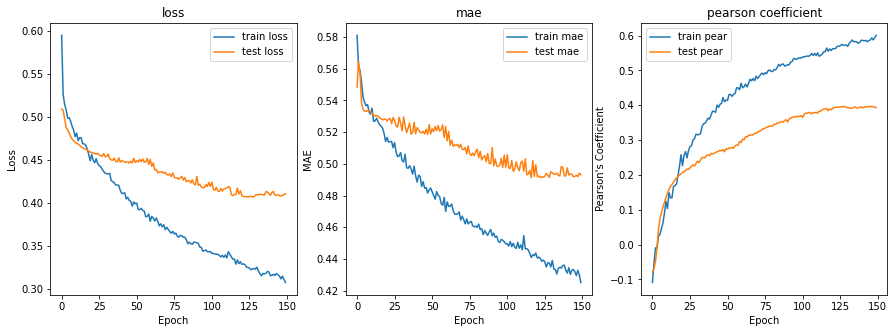

In [48]:

import matplotlib.pyplot as plt
print("Performances for NCE, Fr+ES translation, only conditioned on V")
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.set_ylabel("MAE")
ax2.set_xlabel("Epoch")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")
ax3.set_ylabel("Pearson's Coefficient")
ax3.set_xlabel("Epoch")

# plt.show()

In [49]:
import pickle

with open("/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression_NCE_FR+ESTranslate/training_res_conditioned_V.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

In [50]:
train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

french
testset.len:  52


In [51]:
# evaluate on actual ES data, duptextforNCE
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader,0)
print(test_loss)
print(test_mae)
print(test_pear)

torch.Size([105, 52, 300]) torch.Size([105, 52, 300])
0.8933
0.7794
0.3368


## train with cross-lingual NCE loss, L(T|V)+L(T|A), with french and spanish translated data

In [ ]:

# Instantiate model
model = RegressionModelNCE_(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss(visual=True, audio=True)

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)

# amelia
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]/content/drive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net/dataloader.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return self._deactive((torch.FloatTensor(self.videoText1[vid]),\


torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
598.1312522888184
1.3970752
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
562.4518976211548
1.3972825
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.7386310100555
1.396158
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
423.70714497566223
1.3956367
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   0%|          | 1/250 [00:16<1:06:51, 16.11s/it]

536.0751185417175
1.3951669
Train Loss - MOSEAS Regression:  0.5327
Test Loss - MOSEAS Regression:  0.4868
Train MAE - MOSEAS Regression:  0.5568
Test MAE - MOSEAS Regression:  0.5466
Train Pearson - MOSEAS Regression:  -0.0214
Test Pearson - MOSEAS Regression:  -0.0271
saving checkpoint for epoch 0
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
596.2772313952446
1.3953781
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
663.982177734375
1.3952564
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
488.07524502277374
1.3951585
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
262.1110290288925
1.3953071
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 2/250 [00:34<1:12:49, 17.62s/it]

531.3421010971069
1.3945
Train Loss - MOSEAS Regression:  0.5091
Test Loss - MOSEAS Regression:  0.4826
Train MAE - MOSEAS Regression:  0.5558
Test MAE - MOSEAS Regression:  0.5448
Train Pearson - MOSEAS Regression:  0.0122
Test Pearson - MOSEAS Regression:  0.0175
saving checkpoint for epoch 1
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
566.2624597549438
1.39529
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
723.359393298626
1.3946583
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
457.2436997294426
1.3943801
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
230.48374146223068
1.3946911
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 3/250 [00:51<1:11:42, 17.42s/it]

524.9942650794983
1.3939303
Train Loss - MOSEAS Regression:  0.5007
Test Loss - MOSEAS Regression:  0.4768
Train MAE - MOSEAS Regression:  0.5466
Test MAE - MOSEAS Regression:  0.5313
Train Pearson - MOSEAS Regression:  0.0199
Test Pearson - MOSEAS Regression:  0.108
saving checkpoint for epoch 2
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
586.8400856852531
1.3941727
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
512.6541624069214
1.3938603
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
485.43518257141113
1.3941529
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
370.50738751888275
1.3934801
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 4/250 [01:10<1:13:42, 17.98s/it]

527.6259784698486
1.3934419
Train Loss - MOSEAS Regression:  0.4952
Test Loss - MOSEAS Regression:  0.4792
Train MAE - MOSEAS Regression:  0.538
Test MAE - MOSEAS Regression:  0.5314
Train Pearson - MOSEAS Regression:  0.0535
Test Pearson - MOSEAS Regression:  0.142
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
584.8061558902264
1.3936274
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
522.539083480835
1.3934677
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
565.9120498299599
1.3932271
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
269.53433960676193
1.3931305
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 5/250 [01:29<1:14:20, 18.21s/it]

518.2451920509338
1.3929887
Train Loss - MOSEAS Regression:  0.492
Test Loss - MOSEAS Regression:  0.4707
Train MAE - MOSEAS Regression:  0.5336
Test MAE - MOSEAS Regression:  0.5306
Train Pearson - MOSEAS Regression:  0.0714
Test Pearson - MOSEAS Regression:  0.1443
saving checkpoint for epoch 4
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
520.9406795203686
1.3933098
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
552.0743982791901
1.3928938
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
572.9905934035778
1.3927324
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
252.36926075816154
1.3926904
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 6/250 [01:47<1:14:20, 18.28s/it]

517.0078225135803
1.39258
Train Loss - MOSEAS Regression:  0.4808
Test Loss - MOSEAS Regression:  0.4696
Train MAE - MOSEAS Regression:  0.535
Test MAE - MOSEAS Regression:  0.5355
Train Pearson - MOSEAS Regression:  0.1132
Test Pearson - MOSEAS Regression:  0.1482
saving checkpoint for epoch 5
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
499.5749080777168
1.3925581
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
696.363297522068
1.3925631
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
418.0822653770447
1.3924081
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
313.27824997901917
1.3922124
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 7/250 [02:06<1:14:12, 18.32s/it]

514.60724401474
1.3922073
Train Loss - MOSEAS Regression:  0.4881
Test Loss - MOSEAS Regression:  0.4674
Train MAE - MOSEAS Regression:  0.5407
Test MAE - MOSEAS Regression:  0.533
Train Pearson - MOSEAS Regression:  0.0834
Test Pearson - MOSEAS Regression:  0.1602
saving checkpoint for epoch 6
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
596.6983515322208
1.3920896
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
529.5178937911987
1.3920342
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
440.0139930844307
1.392347
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
314.6916956305504
1.391921
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 8/250 [02:24<1:13:42, 18.27s/it]

513.5787348747253
1.3918781
Train Loss - MOSEAS Regression:  0.4764
Test Loss - MOSEAS Regression:  0.4665
Train MAE - MOSEAS Regression:  0.53
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.1313
Test Pearson - MOSEAS Regression:  0.17
saving checkpoint for epoch 7
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
517.4492220580578
1.3918285
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
455.27336224913597
1.3917645
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
553.122122168541
1.3919529
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
346.9809651374817
1.3914084
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▎         | 9/250 [02:42<1:12:54, 18.15s/it]

512.7549405097961
1.391592
Train Loss - MOSEAS Regression:  0.4743
Test Loss - MOSEAS Regression:  0.4657
Train MAE - MOSEAS Regression:  0.5265
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.1452
Test Pearson - MOSEAS Regression:  0.1765
saving checkpoint for epoch 8
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
552.3399068713188
1.3916647
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
578.732965528965
1.3914908
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
552.8064937591553
1.3914069
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
195.45537972450256
1.3913565
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 10/250 [02:59<1:10:51, 17.71s/it]

511.9943833351135
1.3913224
Train Loss - MOSEAS Regression:  0.476
Test Loss - MOSEAS Regression:  0.465
Train MAE - MOSEAS Regression:  0.5263
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.1404
Test Pearson - MOSEAS Regression:  0.1821
saving checkpoint for epoch 9
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
451.0073722600937
1.391639
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
572.0612765550613
1.391015
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
484.8227760195732
1.3909471
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
342.5853042602539
1.3910958
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 11/250 [03:17<1:11:19, 17.91s/it]

509.8427724838257
1.3910753
Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.4631
Train MAE - MOSEAS Regression:  0.524
Test MAE - MOSEAS Regression:  0.5281
Train Pearson - MOSEAS Regression:  0.1741
Test Pearson - MOSEAS Regression:  0.1871
saving checkpoint for epoch 10
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
439.86603605747223
1.3908712
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
464.96258813142776
1.3908491
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
551.9991445541382
1.3910501
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
361.5055724978447
1.3908522
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▍         | 12/250 [03:35<1:11:14, 17.96s/it]

508.5411458015442
1.3908486
Train Loss - MOSEAS Regression:  0.4606
Test Loss - MOSEAS Regression:  0.4619
Train MAE - MOSEAS Regression:  0.5208
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.2093
Test Pearson - MOSEAS Regression:  0.1914
saving checkpoint for epoch 11
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
540.476925611496
1.3908427
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
544.911039352417
1.39058
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
462.16895174980164
1.390964
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
273.8439302444458
1.3905598
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▌         | 13/250 [03:52<1:09:36, 17.62s/it]

507.98207902908325
1.3906503
Train Loss - MOSEAS Regression:  0.4614
Test Loss - MOSEAS Regression:  0.4614
Train MAE - MOSEAS Regression:  0.5208
Test MAE - MOSEAS Regression:  0.5276
Train Pearson - MOSEAS Regression:  0.2068
Test Pearson - MOSEAS Regression:  0.1952
saving checkpoint for epoch 12
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
450.68470388650894
1.3904155
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
508.5811980366707
1.3905089
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
579.5087172687054
1.3903399
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
278.07947528362274
1.3905652
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 14/250 [04:08<1:08:05, 17.31s/it]

507.2711706161499
1.3904777
Train Loss - MOSEAS Regression:  0.4602
Test Loss - MOSEAS Regression:  0.4607
Train MAE - MOSEAS Regression:  0.5207
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.2128
Test Pearson - MOSEAS Regression:  0.1981
saving checkpoint for epoch 13
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
648.011634349823
1.3902054
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.0515892505646
1.3902782
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
504.8192898631096
1.3905811
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
188.88308238983154
1.3902212
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 15/250 [04:27<1:09:11, 17.66s/it]

508.88352155685425
1.3903065
Train Loss - MOSEAS Regression:  0.4513
Test Loss - MOSEAS Regression:  0.4622
Train MAE - MOSEAS Regression:  0.517
Test MAE - MOSEAS Regression:  0.5254
Train Pearson - MOSEAS Regression:  0.2497
Test Pearson - MOSEAS Regression:  0.2014
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
475.4598757624626
1.3907216
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
518.9553780853748
1.3900626
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
484.7314524054527
1.3899226
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
314.4209682941437
1.3898559
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▋         | 16/250 [04:45<1:08:55, 17.67s/it]

507.9303574562073
1.3901503
Train Loss - MOSEAS Regression:  0.4543
Test Loss - MOSEAS Regression:  0.4613
Train MAE - MOSEAS Regression:  0.5135
Test MAE - MOSEAS Regression:  0.5251
Train Pearson - MOSEAS Regression:  0.2412
Test Pearson - MOSEAS Regression:  0.205
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
518.552628993988
1.389907
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
461.72462153434753
1.3899035
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
494.63118451833725
1.3904114
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
320.18228366971016
1.3896878
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 17/250 [05:02<1:08:38, 17.67s/it]

505.71037673950195
1.3900107
Train Loss - MOSEAS Regression:  0.4547
Test Loss - MOSEAS Regression:  0.4593
Train MAE - MOSEAS Regression:  0.5156
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.2399
Test Pearson - MOSEAS Regression:  0.2091
saving checkpoint for epoch 16
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
563.8369903564453
1.3897576
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
515.6796898841858
1.3897676
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
375.9439026415348
1.3899697
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
315.86850678920746
1.3898835
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 18/250 [05:20<1:08:47, 17.79s/it]

504.67522144317627
1.3898776
Train Loss - MOSEAS Regression:  0.4487
Test Loss - MOSEAS Regression:  0.4584
Train MAE - MOSEAS Regression:  0.5127
Test MAE - MOSEAS Regression:  0.5265
Train Pearson - MOSEAS Regression:  0.2604
Test Pearson - MOSEAS Regression:  0.2123
saving checkpoint for epoch 17
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
528.9284715056419
1.3895724
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
497.0545797049999
1.3897178
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
455.2209527492523
1.3901376
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
279.6522864103317
1.389688
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 19/250 [05:38<1:07:57, 17.65s/it]

505.0022978782654
1.3897493
Train Loss - MOSEAS Regression:  0.4461
Test Loss - MOSEAS Regression:  0.4587
Train MAE - MOSEAS Regression:  0.5108
Test MAE - MOSEAS Regression:  0.5245
Train Pearson - MOSEAS Regression:  0.2709
Test Pearson - MOSEAS Regression:  0.2155
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
532.0438299179077
1.3898835
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
523.1679823994637
1.3894308
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.19268199801445
1.3895354
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
233.59885436296463
1.389333
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 20/250 [05:56<1:08:51, 17.96s/it]

504.41980504989624
1.3896348
Train Loss - MOSEAS Regression:  0.4441
Test Loss - MOSEAS Regression:  0.4582
Train MAE - MOSEAS Regression:  0.5087
Test MAE - MOSEAS Regression:  0.5243
Train Pearson - MOSEAS Regression:  0.2804
Test Pearson - MOSEAS Regression:  0.2186
saving checkpoint for epoch 19
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
556.9222459793091
1.3896668
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
484.7700021266937
1.3894327
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
415.2845633029938
1.389282
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
287.4118706583977
1.3892431
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 21/250 [06:14<1:08:02, 17.83s/it]

503.8710036277771
1.3895363
Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.4577
Train MAE - MOSEAS Regression:  0.5104
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.2864
Test Pearson - MOSEAS Regression:  0.2205
saving checkpoint for epoch 20
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
545.7642653882504
1.3892303
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
438.2729011774063
1.3892462
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
465.88671776652336
1.3893073
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
282.17742070555687
1.3895895
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 22/250 [06:31<1:07:10, 17.68s/it]

502.63235092163086
1.3894343
Train Loss - MOSEAS Regression:  0.4388
Test Loss - MOSEAS Regression:  0.4565
Train MAE - MOSEAS Regression:  0.5098
Test MAE - MOSEAS Regression:  0.5248
Train Pearson - MOSEAS Regression:  0.2998
Test Pearson - MOSEAS Regression:  0.2247
saving checkpoint for epoch 21
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
538.3123947381973
1.3892202
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
465.61634612083435
1.389502
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
510.57143676280975
1.3890795
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
223.30441546440125
1.3891902
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 23/250 [06:49<1:06:58, 17.70s/it]

503.5638327598572
1.3893452
Train Loss - MOSEAS Regression:  0.4402
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5046
Test MAE - MOSEAS Regression:  0.523
Train Pearson - MOSEAS Regression:  0.2957
Test Pearson - MOSEAS Regression:  0.2275
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
526.0680466890335
1.3890343
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
574.1751888394356
1.3894199
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
426.36738044023514
1.3890239
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
195.02659353613853
1.3890243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|▉         | 24/250 [07:06<1:05:49, 17.48s/it]

502.7832384109497
1.3892604
Train Loss - MOSEAS Regression:  0.4362
Test Loss - MOSEAS Regression:  0.4567
Train MAE - MOSEAS Regression:  0.5049
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.3069
Test Pearson - MOSEAS Regression:  0.2294
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
531.5445034503937
1.3891126
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
472.97612315416336
1.3888705
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.04942643642426
1.3894222
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
267.7346773445606
1.3889289
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 25/250 [07:24<1:05:42, 17.52s/it]

500.237859249115
1.3891653
Train Loss - MOSEAS Regression:  0.4333
Test Loss - MOSEAS Regression:  0.4544
Train MAE - MOSEAS Regression:  0.5067
Test MAE - MOSEAS Regression:  0.5239
Train Pearson - MOSEAS Regression:  0.3202
Test Pearson - MOSEAS Regression:  0.2339
saving checkpoint for epoch 24
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.5547305345535
1.3889838
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
509.35786628723145
1.3888246
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
559.5096480250359
1.3892672
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
195.11316525936127
1.3887382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 26/250 [07:41<1:05:22, 17.51s/it]

501.64927911758423
1.3890727
Train Loss - MOSEAS Regression:  0.4318
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5002
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.3242
Test Pearson - MOSEAS Regression:  0.2369
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
527.0259529650211
1.3888495
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
459.0948611497879
1.3888464
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
437.74994361400604
1.3892558
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
279.63186979293823
1.3888035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 27/250 [08:00<1:06:39, 17.93s/it]

499.36773920059204
1.3889923
Train Loss - MOSEAS Regression:  0.4316
Test Loss - MOSEAS Regression:  0.4536
Train MAE - MOSEAS Regression:  0.5018
Test MAE - MOSEAS Regression:  0.5244
Train Pearson - MOSEAS Regression:  0.3237
Test Pearson - MOSEAS Regression:  0.2389
saving checkpoint for epoch 26
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
554.3618717193604
1.3890542
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
440.49496710300446
1.3886187
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
397.34738278388977
1.3886874
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
302.79745477437973
1.3885894
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 28/250 [08:16<1:04:48, 17.52s/it]

499.1987886428833
1.3889079
Train Loss - MOSEAS Regression:  0.4294
Test Loss - MOSEAS Regression:  0.4534
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.3294
Test Pearson - MOSEAS Regression:  0.2418
saving checkpoint for epoch 27
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
391.75065183639526
1.3886585
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
485.5641809105873
1.3886561
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
550.4262846708298
1.3889561
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
251.47860145568848
1.3885425
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 29/250 [08:34<1:04:10, 17.42s/it]

498.5798406600952
1.3888185
Train Loss - MOSEAS Regression:  0.4254
Test Loss - MOSEAS Regression:  0.4529
Train MAE - MOSEAS Regression:  0.4981
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.343
Test Pearson - MOSEAS Regression:  0.2456
saving checkpoint for epoch 28
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
449.2924626171589
1.3890404
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
499.8719173669815
1.3885864
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
514.0221601724625
1.3884969
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
226.60527527332306
1.3886716
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 30/250 [08:53<1:05:27, 17.85s/it]

498.0261697769165
1.3887382
Train Loss - MOSEAS Regression:  0.4281
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4984
Test MAE - MOSEAS Regression:  0.5231
Train Pearson - MOSEAS Regression:  0.3349
Test Pearson - MOSEAS Regression:  0.2484
saving checkpoint for epoch 29
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.3270519375801
1.388959
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
578.8481467962265
1.3884147
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
363.0780672132969
1.3885591
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
266.87130868434906
1.38836
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 31/250 [09:11<1:05:36, 17.97s/it]

498.413818359375
1.3886647
Train Loss - MOSEAS Regression:  0.4214
Test Loss - MOSEAS Regression:  0.4527
Train MAE - MOSEAS Regression:  0.4959
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.3554
Test Pearson - MOSEAS Regression:  0.2516
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
443.085569858551
1.3884484
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
449.1506319344044
1.3884819
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
535.7131329774857
1.3886893
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
214.93225342035294
1.3883278
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 32/250 [09:28<1:04:42, 17.81s/it]

498.0113968849182
1.3885841
Train Loss - MOSEAS Regression:  0.4163
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4941
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.369
Test Pearson - MOSEAS Regression:  0.2554
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
528.5578495264053
1.3882754
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
446.78821325302124
1.3887035
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
491.70217898488045
1.388329
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
183.29791301488876
1.3882257
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 33/250 [09:46<1:04:11, 17.75s/it]

497.2905192375183
1.388506
Train Loss - MOSEAS Regression:  0.4182
Test Loss - MOSEAS Regression:  0.4517
Train MAE - MOSEAS Regression:  0.4914
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.365
Test Pearson - MOSEAS Regression:  0.2582
saving checkpoint for epoch 32
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
464.75573602318764
1.388164
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
496.05803632736206
1.3885576
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
403.6505227088928
1.388401
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
280.2215254306793
1.3881466
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▎        | 34/250 [10:04<1:04:10, 17.83s/it]

494.68792390823364
1.3884275
Train Loss - MOSEAS Regression:  0.4167
Test Loss - MOSEAS Regression:  0.4493
Train MAE - MOSEAS Regression:  0.4957
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.3716
Test Pearson - MOSEAS Regression:  0.2618
saving checkpoint for epoch 33
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
410.7150385379791
1.3885891
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.2750373184681
1.3882093
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
406.41272377967834
1.3880422
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
286.6315077841282
1.3881025
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 35/250 [10:22<1:04:11, 17.92s/it]

494.0990152359009
1.3883526
Train Loss - MOSEAS Regression:  0.4113
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4894
Test MAE - MOSEAS Regression:  0.5198
Train Pearson - MOSEAS Regression:  0.3837
Test Pearson - MOSEAS Regression:  0.2651
saving checkpoint for epoch 34
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
507.718424141407
1.3883317
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
524.9150595664978
1.3882263
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
339.32154190540314
1.3879952
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
247.72557151317596
1.3879842
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 36/250 [10:39<1:03:03, 17.68s/it]

498.17689275741577
1.3882909
Train Loss - MOSEAS Regression:  0.4104
Test Loss - MOSEAS Regression:  0.4525
Train MAE - MOSEAS Regression:  0.4911
Test MAE - MOSEAS Regression:  0.5245
Train Pearson - MOSEAS Regression:  0.3854
Test Pearson - MOSEAS Regression:  0.2653
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
465.16036677360535
1.3880506
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
455.2069230079651
1.3881179
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
472.3568245768547
1.3880422
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
244.52223029732704
1.3884522
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▍        | 37/250 [10:57<1:03:11, 17.80s/it]

492.8600335121155
1.3882339
Train Loss - MOSEAS Regression:  0.4148
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.4931
Test MAE - MOSEAS Regression:  0.5184
Train Pearson - MOSEAS Regression:  0.3722
Test Pearson - MOSEAS Regression:  0.27
saving checkpoint for epoch 36
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
468.9046401977539
1.3879955
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.90095114707947
1.3883588
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
378.9508958160877
1.3881083
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
332.65265160799026
1.3879886
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▌        | 38/250 [11:16<1:04:11, 18.17s/it]

491.56653356552124
1.3881752
Train Loss - MOSEAS Regression:  0.4103
Test Loss - MOSEAS Regression:  0.4465
Train MAE - MOSEAS Regression:  0.4928
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.3853
Test Pearson - MOSEAS Regression:  0.2724
saving checkpoint for epoch 37
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.2810080051422
1.3880653
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
434.9436056613922
1.3879278
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
568.7540304660797
1.3882347
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
218.39808547496796
1.3878183
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 39/250 [11:34<1:03:43, 18.12s/it]

490.69957208633423
1.3881226
Train Loss - MOSEAS Regression:  0.4093
Test Loss - MOSEAS Regression:  0.4457
Train MAE - MOSEAS Regression:  0.4874
Test MAE - MOSEAS Regression:  0.5182
Train Pearson - MOSEAS Regression:  0.3923
Test Pearson - MOSEAS Regression:  0.2751
saving checkpoint for epoch 38
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
400.86619848012924
1.3878334
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
428.32848501205444
1.3880231
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
435.85371109843254
1.3879702
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
356.73591870069504
1.3879514
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 40/250 [11:52<1:02:44, 17.93s/it]

490.4702796936035
1.3880707
Train Loss - MOSEAS Regression:  0.4109
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4933
Test MAE - MOSEAS Regression:  0.5184
Train Pearson - MOSEAS Regression:  0.3899
Test Pearson - MOSEAS Regression:  0.2774
saving checkpoint for epoch 39
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
435.66132098436356
1.3877693
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
426.5610342621803
1.3882389
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
493.4315865635872
1.3877509
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
219.25001645088196
1.3879019
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▋        | 41/250 [12:10<1:02:37, 17.98s/it]

489.62769842147827
1.3880229
Train Loss - MOSEAS Regression:  0.3991
Test Loss - MOSEAS Regression:  0.4448
Train MAE - MOSEAS Regression:  0.4826
Test MAE - MOSEAS Regression:  0.5166
Train Pearson - MOSEAS Regression:  0.4165
Test Pearson - MOSEAS Regression:  0.2806
saving checkpoint for epoch 40
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
430.1911586523056
1.3878043
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
485.3864500820637
1.3877015
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
437.66861993074417
1.3880955
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
241.1630277633667
1.387878
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 42/250 [12:28<1:02:47, 18.11s/it]

489.9601049423218
1.3879724
Train Loss - MOSEAS Regression:  0.404
Test Loss - MOSEAS Regression:  0.4451
Train MAE - MOSEAS Regression:  0.4883
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4034
Test Pearson - MOSEAS Regression:  0.2819
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
473.3391754627228
1.3876256
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
388.9197762608528
1.3877466
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.28350257873535
1.3880239
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
283.96060585975647
1.3876611
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 43/250 [12:45<1:01:25, 17.81s/it]

488.36792278289795
1.3879223
Train Loss - MOSEAS Regression:  0.3965
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4804
Test MAE - MOSEAS Regression:  0.5167
Train Pearson - MOSEAS Regression:  0.4232
Test Pearson - MOSEAS Regression:  0.2837
saving checkpoint for epoch 42
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
522.2666121721268
1.3880001
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
368.70001435279846
1.3876643
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
432.6811950802803
1.3877203
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
251.50970041751862
1.3877175
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 44/250 [13:04<1:01:41, 17.97s/it]

491.11373949050903
1.3878744
Train Loss - MOSEAS Regression:  0.3992
Test Loss - MOSEAS Regression:  0.4461
Train MAE - MOSEAS Regression:  0.4849
Test MAE - MOSEAS Regression:  0.5188
Train Pearson - MOSEAS Regression:  0.4149
Test Pearson - MOSEAS Regression:  0.2812
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.8035852909088
1.3877549
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
390.51054283976555
1.3875561
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
474.8522459566593
1.3879826
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
268.50918024778366
1.3875346
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 45/250 [13:21<1:01:10, 17.90s/it]

489.5244197845459
1.3878388
Train Loss - MOSEAS Regression:  0.399
Test Loss - MOSEAS Regression:  0.4447
Train MAE - MOSEAS Regression:  0.485
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4144
Test Pearson - MOSEAS Regression:  0.2854
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
453.95153760910034
1.387944
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
468.80482310056686
1.3876452
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
400.8228734135628
1.3876128
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
226.81484985351562
1.3876193
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 46/250 [13:40<1:01:09, 17.99s/it]

491.48335790634155
1.3877932
Train Loss - MOSEAS Regression:  0.3929
Test Loss - MOSEAS Regression:  0.4464
Train MAE - MOSEAS Regression:  0.4796
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.2848
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
483.67814150452614
1.3876495
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
385.7006746530533
1.387607
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
442.7505363225937
1.3877404
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
246.96960550546646
1.3878279
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 47/250 [13:57<1:00:44, 17.95s/it]

490.492817401886
1.3877549
Train Loss - MOSEAS Regression:  0.3951
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.427
Test Pearson - MOSEAS Regression:  0.2871
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
398.54371359944344
1.3875537
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
469.63998222351074
1.3877655
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
472.8924986720085
1.3875139
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
219.00013715028763
1.3874781
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 48/250 [14:14<59:32, 17.68s/it]  

491.7316017150879
1.3877163
Train Loss - MOSEAS Regression:  0.3954
Test Loss - MOSEAS Regression:  0.4467
Train MAE - MOSEAS Regression:  0.4811
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4246
Test Pearson - MOSEAS Regression:  0.2867
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
467.8374598622322
1.3874614
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
484.0767570734024
1.3875434
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.83386662602425
1.3877863
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
184.3629091978073
1.3875561
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|█▉        | 49/250 [14:33<59:42, 17.82s/it]

490.6161332130432
1.3876836
Train Loss - MOSEAS Regression:  0.3941
Test Loss - MOSEAS Regression:  0.4457
Train MAE - MOSEAS Regression:  0.4835
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4286
Test Pearson - MOSEAS Regression:  0.2893
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
415.48705184459686
1.3877542
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
362.6047432422638
1.3875146
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
502.55479869246483
1.3874397
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
256.31008487939835
1.3874761
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 50/250 [14:51<59:45, 17.93s/it]

492.07565546035767
1.3876467
Train Loss - MOSEAS Regression:  0.3895
Test Loss - MOSEAS Regression:  0.447
Train MAE - MOSEAS Regression:  0.4761
Test MAE - MOSEAS Regression:  0.5191
Train Pearson - MOSEAS Regression:  0.4394
Test Pearson - MOSEAS Regression:  0.2899
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
446.0228379666805
1.3877383
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
470.98808911442757
1.3874519
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
341.2719011902809
1.387422
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
278.37849992513657
1.3874354
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 51/250 [15:09<59:54, 18.06s/it]

488.3230447769165
1.3876208
Train Loss - MOSEAS Regression:  0.3894
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4786
Test MAE - MOSEAS Regression:  0.5159
Train Pearson - MOSEAS Regression:  0.4407
Test Pearson - MOSEAS Regression:  0.2947
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
449.38798040151596
1.3877268
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
392.1663810610771
1.3874896
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
412.71553072333336
1.3874369
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
278.1741988658905
1.3873882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 52/250 [15:27<59:39, 18.08s/it]

488.84022760391235
1.3876002
Train Loss - MOSEAS Regression:  0.3884
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4412
Test Pearson - MOSEAS Regression:  0.2955
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
386.0484444499016
1.3875546
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
391.3192668557167
1.3874569
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
585.0421011447906
1.3875546
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
191.99817699193954
1.3873767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 53/250 [15:46<59:32, 18.13s/it]

488.04706478118896
1.3875855
Train Loss - MOSEAS Regression:  0.3939
Test Loss - MOSEAS Regression:  0.4433
Train MAE - MOSEAS Regression:  0.4806
Test MAE - MOSEAS Regression:  0.5154
Train Pearson - MOSEAS Regression:  0.4282
Test Pearson - MOSEAS Regression:  0.2979
saving checkpoint for epoch 52
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
331.1876886487007
1.3874568
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
458.8937759399414
1.3873553
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
459.3018193244934
1.3873904
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
275.39825919270515
1.3874924
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 54/250 [16:02<57:28, 17.59s/it]

486.9190607070923
1.3875642
Train Loss - MOSEAS Regression:  0.3864
Test Loss - MOSEAS Regression:  0.4423
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4446
Test Pearson - MOSEAS Regression:  0.2995
saving checkpoint for epoch 53
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
398.6605718135834
1.3874102
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
431.40468671917915
1.3873644
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
430.1178576052189
1.3876057
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
243.8976519703865
1.3873479
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 55/250 [16:19<56:42, 17.45s/it]

486.14201974868774
1.387544
Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4416
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5146
Train Pearson - MOSEAS Regression:  0.4579
Test Pearson - MOSEAS Regression:  0.3022
saving checkpoint for epoch 54
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
382.185249209404
1.3873171
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
461.5466783642769
1.3876476
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.2490291297436
1.3874049
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
234.27047353982925
1.3873304
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 56/250 [16:37<57:00, 17.63s/it]

485.4434823989868
1.3875256
Train Loss - MOSEAS Regression:  0.3909
Test Loss - MOSEAS Regression:  0.441
Train MAE - MOSEAS Regression:  0.4817
Test MAE - MOSEAS Regression:  0.5136
Train Pearson - MOSEAS Regression:  0.436
Test Pearson - MOSEAS Regression:  0.3052
saving checkpoint for epoch 55
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
535.3414478898048
1.387553
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
381.40123522281647
1.3873998
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
394.22384226322174
1.3873174
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
212.69617080688477
1.3873167
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 57/250 [16:54<56:04, 17.43s/it]

493.53050565719604
1.3875003
Train Loss - MOSEAS Regression:  0.3862
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4745
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4503
Test Pearson - MOSEAS Regression:  0.3019
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
466.14604115486145
1.3873653
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.6464154422283
1.3875375
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
390.98212191462517
1.387387
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
248.20030945539474
1.3872331
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 58/250 [17:12<56:38, 17.70s/it]

488.10026693344116
1.3874807
Train Loss - MOSEAS Regression:  0.3845
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4795
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4597
Test Pearson - MOSEAS Regression:  0.3072
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
551.2486502528191
1.3872678
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
308.483441054821
1.3873378
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
433.5372269153595
1.3875692
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
225.9940106868744
1.3872828
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▎       | 59/250 [17:30<56:14, 17.67s/it]

490.36765909194946
1.3874495
Train Loss - MOSEAS Regression:  0.3851
Test Loss - MOSEAS Regression:  0.4454
Train MAE - MOSEAS Regression:  0.4739
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.455
Test Pearson - MOSEAS Regression:  0.3052
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.1951183080673
1.3875003
torch.Size([39, 64, 300]) torch.Size([39, 64, 300])
332.8240407705307
1.3872437
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.9022237360477
1.3872366
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
246.74884763360023
1.38729
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 60/250 [17:47<55:14, 17.44s/it]

485.0184574127197
1.3874309
Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4406
Train MAE - MOSEAS Regression:  0.4789
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4604
Test Pearson - MOSEAS Regression:  0.3092
saving checkpoint for epoch 59
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
427.51545667648315
1.387267
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
408.62914061546326
1.3872259
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
509.2908911406994
1.3872786
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
177.30355009436607
1.3875301
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 61/250 [18:04<55:04, 17.49s/it]

487.51737928390503
1.3874081
Train Loss - MOSEAS Regression:  0.3859
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5151
Train Pearson - MOSEAS Regression:  0.4556
Test Pearson - MOSEAS Regression:  0.3076
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
505.3242976665497
1.3874015
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
365.5372193455696
1.3872213
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
371.5044856071472
1.3872828
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
251.96075397729874
1.3873061
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▍       | 62/250 [18:22<55:02, 17.57s/it]

483.937864780426
1.3873887
Train Loss - MOSEAS Regression:  0.3788
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4737
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4689
Test Pearson - MOSEAS Regression:  0.3099
saving checkpoint for epoch 61
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
357.0394402742386
1.3872485
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
419.80272817611694
1.3872378
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
529.2728115916252
1.3872074
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
190.18346428871155
1.3874484
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▌       | 63/250 [18:39<54:14, 17.40s/it]

483.6035170555115
1.3873734
Train Loss - MOSEAS Regression:  0.3793
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.4646
Test Pearson - MOSEAS Regression:  0.3117
saving checkpoint for epoch 62
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
368.34944242239
1.3872509
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
414.32009840011597
1.3871721
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
421.69652742147446
1.3874668
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
276.9965879917145
1.3871305
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 64/250 [18:57<54:42, 17.65s/it]

482.8528633117676
1.3873533
Train Loss - MOSEAS Regression:  0.3755
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5114
Train Pearson - MOSEAS Regression:  0.4706
Test Pearson - MOSEAS Regression:  0.3139
saving checkpoint for epoch 63
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
393.86762326955795
1.3874186
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
450.45496702194214
1.387219
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
384.85583740472794
1.3871412
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
244.8829571902752
1.3871102
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 65/250 [19:15<54:08, 17.56s/it]

481.8667645454407
1.3873293
Train Loss - MOSEAS Regression:  0.3736
Test Loss - MOSEAS Regression:  0.4377
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.511
Train Pearson - MOSEAS Regression:  0.4753
Test Pearson - MOSEAS Regression:  0.3169
saving checkpoint for epoch 64
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
369.0811091661453
1.3871752
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
429.081231713295
1.3873892
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
394.17566657066345
1.3871753
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
277.4684674143791
1.3871074
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▋       | 66/250 [19:33<54:13, 17.68s/it]

481.9942259788513
1.3873053
Train Loss - MOSEAS Regression:  0.3726
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.468
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4783
Test Pearson - MOSEAS Regression:  0.3187
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
450.7804388701916
1.387145
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.06188678741455
1.3871641
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.95880150794983
1.3873897
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
237.84569630026817
1.3870776
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 67/250 [19:51<54:10, 17.76s/it]

481.9918899536133
1.3872838
Train Loss - MOSEAS Regression:  0.3708
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.4664
Test MAE - MOSEAS Regression:  0.5108
Train Pearson - MOSEAS Regression:  0.4805
Test Pearson - MOSEAS Regression:  0.319
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.5121605396271
1.3873312
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
409.9279079735279
1.387085
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
395.6872571706772
1.3870933
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
202.85347962379456
1.3871138
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 68/250 [20:07<52:39, 17.36s/it]

482.7357659339905
1.3872664
Train Loss - MOSEAS Regression:  0.3708
Test Loss - MOSEAS Regression:  0.4385
Train MAE - MOSEAS Regression:  0.4669
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.48
Test Pearson - MOSEAS Regression:  0.3188
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
475.1271948516369
1.3870903
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.9719207584858
1.3871319
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
322.76390862464905
1.3871326
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
216.03832259774208
1.3873551
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 69/250 [20:25<52:34, 17.43s/it]

481.1221318244934
1.3872508
Train Loss - MOSEAS Regression:  0.3711
Test Loss - MOSEAS Regression:  0.4371
Train MAE - MOSEAS Regression:  0.4666
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.4793
Test Pearson - MOSEAS Regression:  0.321
saving checkpoint for epoch 68
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
514.8812401294708
1.3871
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
396.84094059467316
1.387145
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
375.4998028576374
1.3873055
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
162.01318261027336
1.3870635
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 70/250 [20:42<52:24, 17.47s/it]

486.41750621795654
1.387236
Train Loss - MOSEAS Regression:  0.3674
Test Loss - MOSEAS Regression:  0.4419
Train MAE - MOSEAS Regression:  0.4632
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4884
Test Pearson - MOSEAS Regression:  0.3189
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.8402862548828
1.3870873
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
401.82236808538437
1.3870522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
457.17517709732056
1.387246
torch.Size([32, 36, 300]) torch.Size([32, 36, 300])
159.83087047934532
1.387142
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 71/250 [20:58<50:37, 16.97s/it]

483.21478271484375
1.3872219
Train Loss - MOSEAS Regression:  0.3723
Test Loss - MOSEAS Regression:  0.439
Train MAE - MOSEAS Regression:  0.4685
Test MAE - MOSEAS Regression:  0.5099
Train Pearson - MOSEAS Regression:  0.4779
Test Pearson - MOSEAS Regression:  0.3229
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
406.04756450653076
1.3870583
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
399.39458549022675
1.387122
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
344.8763920068741
1.3870617
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
304.7759379148483
1.3871523
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 72/250 [21:15<50:01, 16.86s/it]

483.0807409286499
1.3872058
Train Loss - MOSEAS Regression:  0.3688
Test Loss - MOSEAS Regression:  0.4388
Train MAE - MOSEAS Regression:  0.4638
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.484
Test Pearson - MOSEAS Regression:  0.3242
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.54350170493126
1.3870614
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
395.47247663140297
1.3870889
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
320.4436027407646
1.3870467
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
263.54369685053825
1.3872123
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 73/250 [21:32<49:48, 16.88s/it]

480.55398416519165
1.387191
Train Loss - MOSEAS Regression:  0.366
Test Loss - MOSEAS Regression:  0.4365
Train MAE - MOSEAS Regression:  0.4643
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.49
Test Pearson - MOSEAS Regression:  0.3266
saving checkpoint for epoch 72
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
466.31908214092255
1.3872178
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
364.07593035697937
1.3870876
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
356.9343311190605
1.3870214
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
254.94614535570145
1.3870666
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|██▉       | 74/250 [21:49<50:09, 17.10s/it]

478.68476915359497
1.3871737
Train Loss - MOSEAS Regression:  0.3656
Test Loss - MOSEAS Regression:  0.4348
Train MAE - MOSEAS Regression:  0.4636
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.4921
Test Pearson - MOSEAS Regression:  0.3278
saving checkpoint for epoch 73
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
425.2099072933197
1.387027
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
365.28389275074005
1.3870711
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
466.4155574440956
1.387054
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
190.41808608174324
1.3872552
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 75/250 [22:07<50:34, 17.34s/it]

479.4358506202698
1.3871531
Train Loss - MOSEAS Regression:  0.3669
Test Loss - MOSEAS Regression:  0.4355
Train MAE - MOSEAS Regression:  0.4638
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.489
Test Pearson - MOSEAS Regression:  0.3267
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
396.86048126220703
1.387064
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
467.5947998762131
1.3871671
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
417.2071498632431
1.3869795
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
157.42894291877747
1.3869829
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 76/250 [22:25<50:36, 17.45s/it]

477.89417266845703
1.3871334
Train Loss - MOSEAS Regression:  0.3648
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4644
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.4928
Test Pearson - MOSEAS Regression:  0.3292
saving checkpoint for epoch 75
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.53607216477394
1.387175
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
459.50080499053
1.386956
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.7783754467964
1.3870658
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
188.3570585846901
1.3869603
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 77/250 [22:42<50:10, 17.40s/it]

476.1475167274475
1.3871167
Train Loss - MOSEAS Regression:  0.3641
Test Loss - MOSEAS Regression:  0.4325
Train MAE - MOSEAS Regression:  0.4609
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.4944
Test Pearson - MOSEAS Regression:  0.334
saving checkpoint for epoch 76
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.9879620075226
1.3869784
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
394.37001371383667
1.3869923
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
383.37474954128265
1.3870429
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
256.4342061281204
1.3871572
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 78/250 [23:00<50:10, 17.51s/it]

476.39431285858154
1.3870994
Train Loss - MOSEAS Regression:  0.362
Test Loss - MOSEAS Regression:  0.4328
Train MAE - MOSEAS Regression:  0.4621
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.4991
Test Pearson - MOSEAS Regression:  0.3357
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.0192114710808
1.3869607
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
373.2719845175743
1.3869728
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.2071464061737
1.3871543
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
206.2162122130394
1.3869355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 79/250 [23:18<50:04, 17.57s/it]

475.8265929222107
1.387084
Train Loss - MOSEAS Regression:  0.3667
Test Loss - MOSEAS Regression:  0.4323
Train MAE - MOSEAS Regression:  0.463
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.4886
Test Pearson - MOSEAS Regression:  0.3372
saving checkpoint for epoch 78
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
336.990318775177
1.3870173
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
404.844742000103
1.3871408
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
440.8042760193348
1.3869388
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
231.46978586912155
1.3869095
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 80/250 [23:36<50:30, 17.83s/it]

474.5778064727783
1.3870696
Train Loss - MOSEAS Regression:  0.3585
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.4594
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5087
Test Pearson - MOSEAS Regression:  0.3399
saving checkpoint for epoch 79
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
347.69644010066986
1.3870058
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
459.96321016550064
1.3870816
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
424.6259710788727
1.3869324
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
197.98199129104614
1.3869293
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 81/250 [23:54<50:16, 17.85s/it]

482.58372688293457
1.3870548
Train Loss - MOSEAS Regression:  0.3626
Test Loss - MOSEAS Regression:  0.4384
Train MAE - MOSEAS Regression:  0.4605
Test MAE - MOSEAS Regression:  0.512
Train Pearson - MOSEAS Regression:  0.4992
Test Pearson - MOSEAS Regression:  0.3366
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
399.61138367652893
1.3869516
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
439.2227922677994
1.3871148
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
307.28655993938446
1.3869534
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
294.6749038696289
1.3869245
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 82/250 [24:12<50:25, 18.01s/it]

477.1541132926941
1.387046
Train Loss - MOSEAS Regression:  0.3652
Test Loss - MOSEAS Regression:  0.4335
Train MAE - MOSEAS Regression:  0.4641
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.4931
Test Pearson - MOSEAS Regression:  0.3423
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
450.9605852365494
1.3869283
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
324.1506573855877
1.3869162
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
474.4176490008831
1.3868963
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
175.0737648010254
1.3871144
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 83/250 [24:29<48:46, 17.53s/it]

473.34731340408325
1.3870277
Train Loss - MOSEAS Regression:  0.3611
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4607
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5004
Test Pearson - MOSEAS Regression:  0.3432
saving checkpoint for epoch 82
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
432.47597590088844
1.3870413
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
315.5744559466839
1.3869855
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
447.89185106754303
1.3869487
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
212.6030671596527
1.3869178
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▎      | 84/250 [24:48<49:46, 17.99s/it]

470.94844579696655
1.3870168
Train Loss - MOSEAS Regression:  0.3571
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5102
Test Pearson - MOSEAS Regression:  0.3476
saving checkpoint for epoch 83
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
432.56073838472366
1.3869097
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
392.78334856033325
1.3869424
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
342.9624748826027
1.387105
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
254.99324986338615
1.386903
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])
470.63640546798706
1.3870046
Train Loss - MOSEAS Regression:  0.3608
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5022
Test Pearson - MOSEAS Regression:  0.3488
saving checkpoint for epoch 84


MOSEAS Regression:  34%|███▍      | 85/250 [25:06<49:20, 17.94s/it]

torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
443.0339830517769
1.3870203
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
414.6578639447689
1.3868991
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
312.2409191131592
1.3869407
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
230.48434710502625
1.3868864
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▍      | 86/250 [25:22<47:55, 17.53s/it]

470.7773895263672
1.3869951
Train Loss - MOSEAS Regression:  0.355
Test Loss - MOSEAS Regression:  0.4277
Train MAE - MOSEAS Regression:  0.4571
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5134
Test Pearson - MOSEAS Regression:  0.3491
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
441.26459062099457
1.3868717
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
389.64045694470406
1.3868916
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
370.16810765862465
1.3870373
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
204.57265377044678
1.3869014
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▍      | 87/250 [25:39<47:02, 17.31s/it]

468.407705783844
1.3869883
Train Loss - MOSEAS Regression:  0.3564
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5011
Train Pearson - MOSEAS Regression:  0.5114
Test Pearson - MOSEAS Regression:  0.3515
saving checkpoint for epoch 86
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
364.6507620513439
1.3869345
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
369.1535025537014
1.3869269
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
460.1573547720909
1.3870039
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
217.37425979971886
1.3869004
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▌      | 88/250 [25:57<47:09, 17.46s/it]

471.60973834991455
1.3869836
Train Loss - MOSEAS Regression:  0.3578
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.5075
Test Pearson - MOSEAS Regression:  0.3515
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
365.69052851200104
1.3869287
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
470.9319007396698
1.386989
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
326.71964448690414
1.3869314
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
230.7460037767887
1.386921
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 89/250 [26:16<48:02, 17.91s/it]

467.9481997489929
1.3869787
Train Loss - MOSEAS Regression:  0.3534
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4582
Test MAE - MOSEAS Regression:  0.5007
Train Pearson - MOSEAS Regression:  0.5164
Test Pearson - MOSEAS Regression:  0.3548
saving checkpoint for epoch 88
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
377.86264634132385
1.387037
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
400.9867305159569
1.3869503
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
420.3159734606743
1.3868732
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
191.0204758644104
1.3870708
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 90/250 [26:34<47:41, 17.88s/it]

470.17601108551025
1.3869675
Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4271
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5185
Test Pearson - MOSEAS Regression:  0.3552
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
340.9503198862076
1.3870783
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
326.49612843990326
1.3868717
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
431.1031413078308
1.3868477
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
292.0091616511345
1.3868382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▋      | 91/250 [26:51<47:14, 17.83s/it]

466.8074297904968
1.3869581
Train Loss - MOSEAS Regression:  0.3526
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4543
Test MAE - MOSEAS Regression:  0.5001
Train Pearson - MOSEAS Regression:  0.5186
Test Pearson - MOSEAS Regression:  0.358
saving checkpoint for epoch 90
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
412.74814799427986
1.3870091
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
432.8130985200405
1.3868304
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
340.44610249996185
1.3869326
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
202.47504436969757
1.3868297
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 92/250 [27:10<47:24, 18.00s/it]

467.96080112457275
1.3869452
Train Loss - MOSEAS Regression:  0.352
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4545
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5191
Test Pearson - MOSEAS Regression:  0.3575
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
292.47071412205696
1.38687
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
398.8546550273895
1.3869946
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
489.0110008120537
1.3868135
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
201.1326160132885
1.3868654
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 93/250 [27:27<46:42, 17.85s/it]

466.8607635498047
1.386935
Train Loss - MOSEAS Regression:  0.3503
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4549
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5226
Test Pearson - MOSEAS Regression:  0.3582
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
430.79553747177124
1.3869586
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
376.8658458888531
1.3868452
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
416.76429176330566
1.3868482
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
158.5537161231041
1.3868544
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 94/250 [27:44<45:15, 17.41s/it]

466.87014055252075
1.3869238
Train Loss - MOSEAS Regression:  0.3506
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4555
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5217
Test Pearson - MOSEAS Regression:  0.3593
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
323.6630852520466
1.3868454
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
385.71375048160553
1.3868761
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
412.25569665431976
1.3869267
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
257.3223931789398
1.3868057
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 95/250 [28:01<44:57, 17.40s/it]

464.5430974960327
1.3869117
Train Loss - MOSEAS Regression:  0.3496
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.452
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5238
Test Pearson - MOSEAS Regression:  0.3616
saving checkpoint for epoch 94
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
337.6031792163849
1.3868096
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
418.19722190499306
1.3868318
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
395.90765368938446
1.3868452
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
223.55263829231262
1.3869387
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 96/250 [28:18<44:31, 17.35s/it]

465.7737879753113
1.3869029
Train Loss - MOSEAS Regression:  0.3487
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4559
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.5267
Test Pearson - MOSEAS Regression:  0.3639
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
389.6288985013962
1.3868179
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
318.3826093673706
1.386978
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
409.8800023198128
1.3868213
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
263.3449923992157
1.3867972
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 97/250 [28:35<44:09, 17.32s/it]

466.1244878768921
1.3868864
Train Loss - MOSEAS Regression:  0.3502
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4536
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.525
Test Pearson - MOSEAS Regression:  0.3657
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
417.2098934650421
1.3869245
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
287.3195677995682
1.3867911
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
358.8188362419605
1.3868065
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
300.7916230559349
1.3867848
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 98/250 [28:53<44:07, 17.42s/it]

459.9908423423767
1.3868759
Train Loss - MOSEAS Regression:  0.3459
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5313
Test Pearson - MOSEAS Regression:  0.3706
saving checkpoint for epoch 97
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
415.3594602942467
1.386823
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
396.99864333868027
1.3869195
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
381.9530054628849
1.3867623
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
166.8981553018093
1.3868287
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|███▉      | 99/250 [29:12<44:58, 17.87s/it]

458.6581563949585
1.3868644
Train Loss - MOSEAS Regression:  0.3451
Test Loss - MOSEAS Regression:  0.4167
Train MAE - MOSEAS Regression:  0.452
Test MAE - MOSEAS Regression:  0.4964
Train Pearson - MOSEAS Regression:  0.5335
Test Pearson - MOSEAS Regression:  0.3726
saving checkpoint for epoch 98
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
372.43260741233826
1.3869128
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
346.52098605036736
1.3867755
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
427.6626053452492
1.3867687
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
212.78742024302483
1.386775
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 100/250 [29:30<44:43, 17.89s/it]

458.50749921798706
1.3868539
Train Loss - MOSEAS Regression:  0.3447
Test Loss - MOSEAS Regression:  0.4166
Train MAE - MOSEAS Regression:  0.4511
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5338
Test Pearson - MOSEAS Regression:  0.3735
saving checkpoint for epoch 99
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
413.4539740085602
1.3868072
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
403.8696174621582
1.386864
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
337.5308712720871
1.3867674
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
211.31064653396606
1.3867612
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 101/250 [29:48<44:30, 17.92s/it]

458.9445333480835
1.3868471
Train Loss - MOSEAS Regression:  0.3464
Test Loss - MOSEAS Regression:  0.417
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5304
Test Pearson - MOSEAS Regression:  0.3739
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
301.74951171875
1.3868119
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
434.7780134379864
1.3867743
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
367.1947579085827
1.3867593
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
242.56966400146484
1.3868382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 102/250 [30:06<44:01, 17.85s/it]

461.96968603134155
1.386842
Train Loss - MOSEAS Regression:  0.3414
Test Loss - MOSEAS Regression:  0.4197
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.4966
Train Pearson - MOSEAS Regression:  0.5415
Test Pearson - MOSEAS Regression:  0.3737
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
422.6162081360817
1.386723
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
393.72074273228645
1.386878
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
351.44953921437263
1.3867273
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
188.07998895645142
1.3867145
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 103/250 [30:22<42:43, 17.44s/it]

465.38666582107544
1.3868282
Train Loss - MOSEAS Regression:  0.3438
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4488
Test MAE - MOSEAS Regression:  0.5029
Train Pearson - MOSEAS Regression:  0.5379
Test Pearson - MOSEAS Regression:  0.3714
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
349.83467876911163
1.3867831
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
357.5834663808346
1.3867648
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
424.65624660253525
1.3868518
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
223.0236291885376
1.3866985
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 104/250 [30:40<43:07, 17.73s/it]

463.98195791244507
1.386822
Train Loss - MOSEAS Regression:  0.3436
Test Loss - MOSEAS Regression:  0.4215
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5367
Test Pearson - MOSEAS Regression:  0.3738
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
381.3308515548706
1.3867252
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
383.3347749710083
1.386754
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
352.41399708390236
1.3867149
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
238.06244838237762
1.3868151
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 105/250 [30:57<42:10, 17.45s/it]

459.72571992874146
1.3868117
Train Loss - MOSEAS Regression:  0.3436
Test Loss - MOSEAS Regression:  0.4177
Train MAE - MOSEAS Regression:  0.4501
Test MAE - MOSEAS Regression:  0.4983
Train Pearson - MOSEAS Regression:  0.5356
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
306.4835713505745
1.3866895
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
392.6547095775604
1.3867202
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
406.5821560025215
1.3868587
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
243.32849726080894
1.3867204
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 106/250 [31:15<41:44, 17.40s/it]

457.03475046157837
1.3868055
Train Loss - MOSEAS Regression:  0.3421
Test Loss - MOSEAS Regression:  0.4152
Train MAE - MOSEAS Regression:  0.4477
Test MAE - MOSEAS Regression:  0.4956
Train Pearson - MOSEAS Regression:  0.5395
Test Pearson - MOSEAS Regression:  0.3778
saving checkpoint for epoch 105
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
382.00570809841156
1.3866974
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.3568878173828
1.3868221
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
356.9754736125469
1.3867645
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
207.87641787528992
1.3867468
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 107/250 [31:33<42:01, 17.63s/it]

461.14710903167725
1.3868012
Train Loss - MOSEAS Regression:  0.3462
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4541
Test MAE - MOSEAS Regression:  0.4958
Train Pearson - MOSEAS Regression:  0.5325
Test Pearson - MOSEAS Regression:  0.3792
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.95733869075775
1.3868334
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
406.6555790901184
1.3867307
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
347.6485208272934
1.3867702
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
199.92827582359314
1.3867207
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 108/250 [31:52<42:35, 18.00s/it]

462.12083673477173
1.3867933
Train Loss - MOSEAS Regression:  0.3464
Test Loss - MOSEAS Regression:  0.4198
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5331
Test Pearson - MOSEAS Regression:  0.3781
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
339.11444675922394
1.3867391
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
352.3350912332535
1.3868651
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
440.9101655483246
1.3866943
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
212.6759616136551
1.3867364
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▎     | 109/250 [32:09<42:07, 17.93s/it]

458.1254439353943
1.3867872
Train Loss - MOSEAS Regression:  0.3411
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5414
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
421.1697190999985
1.3867245
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.86075630784035
1.3867304
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
392.71995559334755
1.3867993
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
161.70538571476936
1.3867841
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 110/250 [32:28<42:14, 18.10s/it]

457.0262289047241
1.3867842
Train Loss - MOSEAS Regression:  0.3402
Test Loss - MOSEAS Regression:  0.4152
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.4958
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
335.6500964164734
1.3868127
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
401.7957203388214
1.3867397
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
383.1437690258026
1.3866844
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
194.6265361905098
1.3867102
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 111/250 [32:45<41:09, 17.76s/it]

458.8054904937744
1.3867811
Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.4168
Train MAE - MOSEAS Regression:  0.4445
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.5559
Test Pearson - MOSEAS Regression:  0.3789
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
386.3895320892334
1.3868254
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
356.23434767127037
1.3866999
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
398.82670998573303
1.3867283
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
182.43347772955894
1.3867017
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▍     | 112/250 [33:03<40:50, 17.76s/it]

458.069149017334
1.3867774
Train Loss - MOSEAS Regression:  0.3357
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.445
Test MAE - MOSEAS Regression:  0.4949
Train Pearson - MOSEAS Regression:  0.5516
Test Pearson - MOSEAS Regression:  0.3793
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
350.38786724209785
1.3867003
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
404.7393543124199
1.3867956
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
282.5694742202759
1.3867435
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
286.83954495191574
1.3867157
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▌     | 113/250 [33:20<40:28, 17.73s/it]

457.1349034309387
1.3867731
Train Loss - MOSEAS Regression:  0.3359
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4441
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.5505
Test Pearson - MOSEAS Regression:  0.3806
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
399.6799783706665
1.3867145
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
304.8898392021656
1.3868399
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
471.6825146973133
1.3866954
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
146.84839010238647
1.3867142
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 114/250 [33:38<40:31, 17.88s/it]

458.08369159698486
1.3867698
Train Loss - MOSEAS Regression:  0.3355
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.4979
Train Pearson - MOSEAS Regression:  0.5519
Test Pearson - MOSEAS Regression:  0.3809
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
376.99491584300995
1.3868115
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
346.15290546417236
1.3867233
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
421.7001984119415
1.3866985
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
181.775763630867
1.3867303
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 115/250 [33:57<40:49, 18.14s/it]

455.5928635597229
1.3867662
Train Loss - MOSEAS Regression:  0.3364
Test Loss - MOSEAS Regression:  0.4139
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.5499
Test Pearson - MOSEAS Regression:  0.3831
saving checkpoint for epoch 114
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
373.5093400776386
1.3866769
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.1639086008072
1.38673
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
378.3477945923805
1.386768
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
202.6437024474144
1.3867847
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])
455.2958264350891
1.3867617
Train Loss - MOSEAS Regression:  0.3346
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5534
Test Pearson - MOSEAS Regression:  0.3844
saving checkpoint for epoch 115


MOSEAS Regression:  46%|████▋     | 116/250 [34:14<39:34, 17.72s/it]

torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
280.52706003189087
1.3867147
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
516.8498611450195
1.3867407
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
328.20776557922363
1.3867512
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
188.53341662883759
1.3866897
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 117/250 [34:31<38:58, 17.58s/it]

460.32397270202637
1.3867615
Train Loss - MOSEAS Regression:  0.3332
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4438
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5562
Test Pearson - MOSEAS Regression:  0.3827
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
331.35870030522346
1.3866917
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
412.3760251700878
1.3867197
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
367.669236689806
1.386684
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
234.42724111676216
1.3867767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 118/250 [34:47<37:35, 17.09s/it]

457.0520238876343
1.3867571
Train Loss - MOSEAS Regression:  0.3413
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3856
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.04677921533585
1.3867483
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
316.66851568222046
1.3867216
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
315.34341767430305
1.3866842
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
247.2558969259262
1.3866956
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 119/250 [35:04<37:23, 17.13s/it]

456.1668348312378
1.3867486
Train Loss - MOSEAS Regression:  0.3341
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4439
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5539
Test Pearson - MOSEAS Regression:  0.3849
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
371.5270671546459
1.3868006
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
418.68804332613945
1.3866667
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
320.7436009645462
1.386703
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
196.2093961238861
1.3866596
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 120/250 [35:23<37:56, 17.51s/it]

454.42708826065063
1.386737
Train Loss - MOSEAS Regression:  0.3315
Test Loss - MOSEAS Regression:  0.4129
Train MAE - MOSEAS Regression:  0.4426
Test MAE - MOSEAS Regression:  0.4949
Train Pearson - MOSEAS Regression:  0.5593
Test Pearson - MOSEAS Regression:  0.3855
saving checkpoint for epoch 119
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
402.8072655200958
1.3867366
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
471.5671115517616
1.386662
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
261.82971727848053
1.3867149
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
166.5044236779213
1.3867035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 121/250 [35:42<38:31, 17.92s/it]

455.4173655509949
1.3867266
Train Loss - MOSEAS Regression:  0.3304
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.442
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5626
Test Pearson - MOSEAS Regression:  0.3857
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
295.60338592529297
1.386663
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.2182083427906
1.3867306
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
439.24086225032806
1.3866575
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
167.89009854197502
1.3866645
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 122/250 [35:59<37:56, 17.79s/it]

458.7499852180481
1.3867185
Train Loss - MOSEAS Regression:  0.3332
Test Loss - MOSEAS Regression:  0.4168
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5579
Test Pearson - MOSEAS Regression:  0.3821
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
357.7789306640625
1.3866636
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
327.7051968574524
1.3866844
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
356.92924880981445
1.3866582
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
269.46603441238403
1.3867061
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 123/250 [36:17<37:49, 17.87s/it]

457.4295058250427
1.3867104
Train Loss - MOSEAS Regression:  0.3327
Test Loss - MOSEAS Regression:  0.4156
Train MAE - MOSEAS Regression:  0.4456
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5566
Test Pearson - MOSEAS Regression:  0.386
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
506.71356201171875
1.3866711
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
339.85014939308167
1.3866565
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
311.0401727259159
1.3866849
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
141.93850180506706
1.3866549
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|████▉     | 124/250 [36:35<37:46, 17.99s/it]

460.3927044868469
1.3867035
Train Loss - MOSEAS Regression:  0.3296
Test Loss - MOSEAS Regression:  0.4183
Train MAE - MOSEAS Regression:  0.4391
Test MAE - MOSEAS Regression:  0.5006
Train Pearson - MOSEAS Regression:  0.5631
Test Pearson - MOSEAS Regression:  0.3823
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
315.08729404211044
1.3866532
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
359.4193806052208
1.3866518
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
443.73809576034546
1.3866804
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
179.51450729370117
1.3866355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 125/250 [36:53<36:57, 17.74s/it]

458.90906524658203
1.3866986
Train Loss - MOSEAS Regression:  0.3291
Test Loss - MOSEAS Regression:  0.4169
Train MAE - MOSEAS Regression:  0.4414
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3868
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.9741355776787
1.3866279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.03129640221596
1.3867252
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
382.4575642347336
1.386604
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
207.21720641851425
1.3866768
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 126/250 [37:10<36:40, 17.75s/it]

454.9157452583313
1.3866911
Train Loss - MOSEAS Regression:  0.3309
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.4954
Train Pearson - MOSEAS Regression:  0.5599
Test Pearson - MOSEAS Regression:  0.388
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
336.3065233230591
1.3866464
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
412.10563373565674
1.3866225
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
347.4990841150284
1.3867141
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
197.25930181145668
1.3866342
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 127/250 [37:28<36:35, 17.85s/it]

453.0982189178467
1.3866829
Train Loss - MOSEAS Regression:  0.328
Test Loss - MOSEAS Regression:  0.4117
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5659
Test Pearson - MOSEAS Regression:  0.3899
saving checkpoint for epoch 126
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.4897280931473
1.3867013
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
386.11569929122925
1.3866149
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
344.7101318836212
1.3866293
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
192.55003952980042
1.3866059
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 128/250 [37:46<36:04, 17.74s/it]

455.02106380462646
1.3866765
Train Loss - MOSEAS Regression:  0.3259
Test Loss - MOSEAS Regression:  0.4134
Train MAE - MOSEAS Regression:  0.4375
Test MAE - MOSEAS Regression:  0.4963
Train Pearson - MOSEAS Regression:  0.5696
Test Pearson - MOSEAS Regression:  0.3883
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
363.19195663928986
1.3866136
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
328.1022053062916
1.3865969
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
369.0768789052963
1.3866878
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
223.29193979501724
1.386605
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 129/250 [38:04<35:45, 17.73s/it]

455.4429302215576
1.3866737
Train Loss - MOSEAS Regression:  0.3256
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.57
Test Pearson - MOSEAS Regression:  0.3906
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
384.0251533985138
1.3866212
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
364.11577719449997
1.3866806
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
340.12858790159225
1.3866231
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
185.06422808766365
1.3866068
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 130/250 [38:22<35:34, 17.79s/it]

455.7747116088867
1.3866689
Train Loss - MOSEAS Regression:  0.3229
Test Loss - MOSEAS Regression:  0.4141
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5745
Test Pearson - MOSEAS Regression:  0.3888
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
370.4168818593025
1.3866224
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
324.9010174870491
1.386727
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
307.463027715683
1.3865914
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
277.7289473116398
1.3865888
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 131/250 [38:40<35:38, 17.97s/it]

454.20069122314453
1.3866638
Train Loss - MOSEAS Regression:  0.3248
Test Loss - MOSEAS Regression:  0.4127
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5714
Test Pearson - MOSEAS Regression:  0.3899
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
350.6495589017868
1.386615
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
427.7235050201416
1.3866593
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
289.567112326622
1.3866487
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
216.83916771411896
1.3866112
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 132/250 [38:58<35:34, 18.09s/it]

455.4073634147644
1.3866589
Train Loss - MOSEAS Regression:  0.3258
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4404
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5711
Test Pearson - MOSEAS Regression:  0.392
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
347.6876260638237
1.3866155
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
332.769965082407
1.3866737
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
383.46485140919685
1.3865986
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
228.38907131552696
1.3865929
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 133/250 [39:16<34:46, 17.83s/it]

454.8468818664551
1.3866572
Train Loss - MOSEAS Regression:  0.3277
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4383
Test MAE - MOSEAS Regression:  0.4965
Train Pearson - MOSEAS Regression:  0.5669
Test Pearson - MOSEAS Regression:  0.3904
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.4934767484665
1.3866765
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
334.88923558592796
1.3865876
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
306.14745450019836
1.38659
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
231.22589215636253
1.3865969
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▎    | 134/250 [39:33<34:01, 17.60s/it]

452.10632944107056
1.3866539
Train Loss - MOSEAS Regression:  0.3256
Test Loss - MOSEAS Regression:  0.4108
Train MAE - MOSEAS Regression:  0.4399
Test MAE - MOSEAS Regression:  0.4933
Train Pearson - MOSEAS Regression:  0.5697
Test Pearson - MOSEAS Regression:  0.3937
saving checkpoint for epoch 133
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
341.1262201368809
1.3866074
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
339.97101843357086
1.3865973
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
373.4044221639633
1.3866946
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
232.52233117818832
1.3866035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 135/250 [39:50<33:52, 17.67s/it]

451.04340505599976
1.3866515
Train Loss - MOSEAS Regression:  0.3264
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.4925
Train Pearson - MOSEAS Regression:  0.569
Test Pearson - MOSEAS Regression:  0.3958
saving checkpoint for epoch 134
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
265.1391245126724
1.3865905
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
390.4245537519455
1.3866533
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
372.03317975997925
1.3866066
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
230.7900350689888
1.3865969
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 136/250 [40:09<33:53, 17.84s/it]

449.91161727905273
1.3866485
Train Loss - MOSEAS Regression:  0.3192
Test Loss - MOSEAS Regression:  0.4088
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5816
Test Pearson - MOSEAS Regression:  0.3962
saving checkpoint for epoch 135
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
383.38558316230774
1.3865879
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
336.8457011580467
1.3865728
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
307.6560034751892
1.386593
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
230.34664392471313
1.3866233
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▍    | 137/250 [40:24<32:17, 17.15s/it]

451.1538233757019
1.3866448
Train Loss - MOSEAS Regression:  0.3191
Test Loss - MOSEAS Regression:  0.4099
Train MAE - MOSEAS Regression:  0.4333
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5818
Test Pearson - MOSEAS Regression:  0.3946
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
288.79223120212555
1.3866198
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
490.5176372528076
1.3866417
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
287.42428505420685
1.3865817
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
204.1593102812767
1.3865844
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▌    | 138/250 [40:43<32:39, 17.50s/it]

451.5764465332031
1.3866408
Train Loss - MOSEAS Regression:  0.3223
Test Loss - MOSEAS Regression:  0.4103
Train MAE - MOSEAS Regression:  0.4364
Test MAE - MOSEAS Regression:  0.494
Train Pearson - MOSEAS Regression:  0.5757
Test Pearson - MOSEAS Regression:  0.3936
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
288.32241147756577
1.3866854
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
424.6421854197979
1.3865871
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
382.37999629974365
1.3865526
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
173.29670172929764
1.3865767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 139/250 [41:00<32:31, 17.58s/it]

452.81365156173706
1.3866365
Train Loss - MOSEAS Regression:  0.3218
Test Loss - MOSEAS Regression:  0.4114
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4945
Train Pearson - MOSEAS Regression:  0.5771
Test Pearson - MOSEAS Regression:  0.3917
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
368.09001207351685
1.3865824
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
330.841667085886
1.3865882
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
341.9514638185501
1.3866787
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
218.08181238174438
1.3865628
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 140/250 [41:19<32:44, 17.86s/it]

454.4015564918518
1.3866332
Train Loss - MOSEAS Regression:  0.3193
Test Loss - MOSEAS Regression:  0.4129
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.581
Test Pearson - MOSEAS Regression:  0.3896
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
330.66501170396805
1.3866606
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
276.95598673820496
1.386601
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
388.3902107477188
1.3865911
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
260.48831310868263
1.3865572
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▋    | 141/250 [41:36<32:02, 17.64s/it]

456.0359516143799
1.3866307
Train Loss - MOSEAS Regression:  0.3187
Test Loss - MOSEAS Regression:  0.4143
Train MAE - MOSEAS Regression:  0.4354
Test MAE - MOSEAS Regression:  0.4955
Train Pearson - MOSEAS Regression:  0.5829
Test Pearson - MOSEAS Regression:  0.3895
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.6925103068352
1.3865757
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
296.80790930986404
1.3865645
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.4318301975727
1.386667
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
224.0775614976883
1.3865657
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 142/250 [41:53<31:29, 17.50s/it]

460.7613687515259
1.3866268
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.4186
Train MAE - MOSEAS Regression:  0.4304
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5857
Test Pearson - MOSEAS Regression:  0.3858
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
402.22482177615166
1.3866498
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
349.32825565338135
1.3865619
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
302.743524312973
1.3865888
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
203.5143092572689
1.3865702
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 143/250 [42:11<31:21, 17.59s/it]

455.3502130508423
1.3866227
Train Loss - MOSEAS Regression:  0.319
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4353
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.5817
Test Pearson - MOSEAS Regression:  0.3899
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.29480826854706
1.3865672
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
334.03936418890953
1.3865772
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
327.10759234428406
1.3865592
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
196.6321662068367
1.3866402
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 144/250 [42:28<30:50, 17.46s/it]

454.9278202056885
1.3866163
Train Loss - MOSEAS Regression:  0.3209
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4961
Train Pearson - MOSEAS Regression:  0.5788
Test Pearson - MOSEAS Regression:  0.3889
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
375.2010375261307
1.3865676
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
372.0987377166748
1.3866397
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
324.40188241004944
1.386582
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
176.43291372060776
1.3865469
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 145/250 [42:47<31:09, 17.81s/it]

455.9458336830139
1.38661
Train Loss - MOSEAS Regression:  0.3166
Test Loss - MOSEAS Regression:  0.4143
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5871
Test Pearson - MOSEAS Regression:  0.3879
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
370.8105520308018
1.386546
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
300.8081810474396
1.3866632
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
441.36567664146423
1.386543
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
136.59756043553352
1.3865528
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 146/250 [43:04<30:37, 17.67s/it]

456.76946353912354
1.386606
Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.415
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5853
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
315.53797602653503
1.3865819
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.66857236623764
1.3866148
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
397.1223848462105
1.3865404
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
170.53176084160805
1.3865576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 147/250 [43:23<30:52, 17.98s/it]

459.6502103805542
1.386601
Train Loss - MOSEAS Regression:  0.3158
Test Loss - MOSEAS Regression:  0.4176
Train MAE - MOSEAS Regression:  0.4319
Test MAE - MOSEAS Regression:  0.497
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.3883
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
327.6530137360096
1.3866508
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
356.6099841892719
1.3865552
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
333.20125579833984
1.3865354
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
232.69399166107178
1.3865364
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 148/250 [43:41<30:43, 18.07s/it]

454.53559827804565
1.3865919
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5849
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
341.89035817980766
1.3865585
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
303.50184267759323
1.3866415
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
423.9245949983597
1.386529
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
171.74883791804314
1.3865352
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|█████▉    | 149/250 [43:59<30:20, 18.02s/it]

453.64850091934204
1.3865864
Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4122
Train MAE - MOSEAS Regression:  0.4303
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.589
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
393.6788960695267
1.3865471
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
382.6088933944702
1.3865975
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
275.9849227666855
1.3865614
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
184.04704982042313
1.3865294
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 150/250 [44:17<30:08, 18.09s/it]

454.34924268722534
1.3865836
Train Loss - MOSEAS Regression:  0.3136
Test Loss - MOSEAS Regression:  0.4128
Train MAE - MOSEAS Regression:  0.4304
Test MAE - MOSEAS Regression:  0.496
Train Pearson - MOSEAS Regression:  0.5913
Test Pearson - MOSEAS Regression:  0.3933
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
441.06947404146194
1.3865324
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
322.18391424417496
1.3865345
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
312.72758066654205
1.3865199
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
173.99188768863678
1.3866112
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 151/250 [44:35<29:30, 17.89s/it]

454.5646834373474
1.3865843
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4945
Train Pearson - MOSEAS Regression:  0.5852
Test Pearson - MOSEAS Regression:  0.3952
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
327.3427249789238
1.3865322
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
379.22389113903046
1.3866045
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
319.77397298812866
1.3865578
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
217.14363741874695
1.3865266
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 152/250 [44:52<29:09, 17.85s/it]

453.3737382888794
1.3865814
Train Loss - MOSEAS Regression:  0.3154
Test Loss - MOSEAS Regression:  0.4119
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.396
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
360.798086553812
1.3865336
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
307.71081697940826
1.38656
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
414.7241276502609
1.38657
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
143.45439440011978
1.3865753
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 153/250 [45:10<28:45, 17.78s/it]

452.0238118171692
1.3865776
Train Loss - MOSEAS Regression:  0.3112
Test Loss - MOSEAS Regression:  0.4107
Train MAE - MOSEAS Regression:  0.4273
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5955
Test Pearson - MOSEAS Regression:  0.3968
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
337.4906796216965
1.3865376
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
304.86329954862595
1.3865364
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.9932680130005
1.386584
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
217.1824877858162
1.3865249
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 154/250 [45:28<28:33, 17.84s/it]

452.3067011833191
1.3865747
Train Loss - MOSEAS Regression:  0.3154
Test Loss - MOSEAS Regression:  0.411
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.8860793411732
1.3865732
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
335.5880232453346
1.3865259
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
331.02958327531815
1.386543
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
187.30827793478966
1.386527
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 155/250 [45:45<27:50, 17.59s/it]

453.4284210205078
1.3865738
Train Loss - MOSEAS Regression:  0.314
Test Loss - MOSEAS Regression:  0.412
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4961
Train Pearson - MOSEAS Regression:  0.5904
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
341.8561999797821
1.386539
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
281.8017601966858
1.3865262
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.7407435774803
1.3865738
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
227.18364721536636
1.3865192
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 156/250 [46:03<27:46, 17.73s/it]

455.5018243789673
1.3865741
Train Loss - MOSEAS Regression:  0.3124
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4299
Test MAE - MOSEAS Regression:  0.4943
Train Pearson - MOSEAS Regression:  0.5938
Test Pearson - MOSEAS Regression:  0.3988
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
365.2056837975979
1.3865287
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
341.9859873056412
1.3865273
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.205144405365
1.3866022
torch.Size([41, 36, 300]) torch.Size([41, 36, 300])
156.02508556842804
1.3865824
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 157/250 [46:20<27:19, 17.63s/it]

451.2797055244446
1.3865695
Train Loss - MOSEAS Regression:  0.3098
Test Loss - MOSEAS Regression:  0.41
Train MAE - MOSEAS Regression:  0.4269
Test MAE - MOSEAS Regression:  0.494
Train Pearson - MOSEAS Regression:  0.5977
Test Pearson - MOSEAS Regression:  0.3972
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
280.85003793239594
1.3865178
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
415.4412809610367
1.3865726
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.5268345475197
1.3865465
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
199.42774057388306
1.3865287
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 158/250 [46:38<27:10, 17.72s/it]

451.8465700149536
1.3865662
Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4105
Train MAE - MOSEAS Regression:  0.4277
Test MAE - MOSEAS Regression:  0.4937
Train Pearson - MOSEAS Regression:  0.5945
Test Pearson - MOSEAS Regression:  0.3967
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
345.8672754764557
1.386518
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
302.6801920235157
1.3866053
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
333.0479764640331
1.3865272
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
244.97015243768692
1.3865113
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▎   | 159/250 [46:57<27:04, 17.86s/it]

454.5327687263489
1.3865669
Train Loss - MOSEAS Regression:  0.3111
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.43
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.5957
Test Pearson - MOSEAS Regression:  0.3961
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.91076278686523
1.3865767
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
313.2600648403168
1.3865476
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
313.5751238465309
1.386521
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
229.79422742128372
1.3865263
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 160/250 [47:15<26:59, 17.99s/it]

454.95305585861206
1.3865626
Train Loss - MOSEAS Regression:  0.3091
Test Loss - MOSEAS Regression:  0.4134
Train MAE - MOSEAS Regression:  0.4276
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.599
Test Pearson - MOSEAS Regression:  0.3949
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
299.6189553439617
1.3865318
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
373.61725330352783
1.3865545
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
387.8532485961914
1.3865117
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
159.53978925943375
1.3865169
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 161/250 [47:32<26:21, 17.77s/it]

451.52558040618896
1.3865588
Train Loss - MOSEAS Regression:  0.3096
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4275
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.598
Test Pearson - MOSEAS Regression:  0.3975
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
287.9392002224922
1.3865103
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
334.50947856903076
1.386504
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
440.28087025880814
1.3865392
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
163.1123611330986
1.3865117
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▍   | 162/250 [47:49<25:30, 17.39s/it]

455.115656375885
1.3865587
Train Loss - MOSEAS Regression:  0.311
Test Loss - MOSEAS Regression:  0.4135
Train MAE - MOSEAS Regression:  0.4316
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.5968
Test Pearson - MOSEAS Regression:  0.3988
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
389.91822838783264
1.3865645
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
383.07713752985
1.3865085
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
277.7150784432888
1.3865306
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
170.90073066949844
1.3865299
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▌   | 163/250 [48:08<25:51, 17.84s/it]

456.1162648200989
1.3865534
Train Loss - MOSEAS Regression:  0.3099
Test Loss - MOSEAS Regression:  0.4144
Train MAE - MOSEAS Regression:  0.4285
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3952
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
294.86323618888855
1.3865272
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
370.15058666467667
1.3865029
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
344.95152872800827
1.3865125
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
217.1655897796154
1.3865576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 164/250 [48:25<25:32, 17.82s/it]

453.0641984939575
1.38655
Train Loss - MOSEAS Regression:  0.3113
Test Loss - MOSEAS Regression:  0.4116
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.5953
Test Pearson - MOSEAS Regression:  0.3966
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
339.4318996667862
1.3865578
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
289.77330055832863
1.3865187
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
439.60153245925903
1.3865043
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
140.52587834000587
1.386514
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 165/250 [48:43<25:16, 17.84s/it]

452.73840522766113
1.3865469
Train Loss - MOSEAS Regression:  0.3068
Test Loss - MOSEAS Regression:  0.4113
Train MAE - MOSEAS Regression:  0.4277
Test MAE - MOSEAS Regression:  0.4944
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3974
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
307.05926156044006
1.3865001
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
329.96228232979774
1.3865099
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
299.5748380422592
1.3865268
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
276.8475646972656
1.3865204
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▋   | 166/250 [49:01<24:51, 17.75s/it]

455.3339924812317
1.3865474
Train Loss - MOSEAS Regression:  0.3078
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4263
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.6012
Test Pearson - MOSEAS Regression:  0.3985
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
301.0323825478554
1.3865203
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
329.20538955926895
1.3865485
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
400.7655611038208
1.3865039
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
184.43642178177834
1.3865261
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 167/250 [49:19<24:57, 18.04s/it]

453.78764247894287
1.3865447
Train Loss - MOSEAS Regression:  0.3083
Test Loss - MOSEAS Regression:  0.4123
Train MAE - MOSEAS Regression:  0.4278
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.6003
Test Pearson - MOSEAS Regression:  0.3969
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
347.3842696547508
1.386508
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
287.71099877357483
1.3864992
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.68939086794853
1.386548
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
214.2243264913559
1.3865254
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 168/250 [49:37<24:20, 17.82s/it]

453.43960762023926
1.3865422
Train Loss - MOSEAS Regression:  0.3065
Test Loss - MOSEAS Regression:  0.412
Train MAE - MOSEAS Regression:  0.4272
Test MAE - MOSEAS Regression:  0.4959
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
340.06403481960297
1.3865051
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
359.5620020329952
1.386538
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
348.96717658638954
1.3864963
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
155.0272325873375
1.3865108
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 169/250 [49:54<23:47, 17.62s/it]

453.82498598098755
1.3865427
Train Loss - MOSEAS Regression:  0.3053
Test Loss - MOSEAS Regression:  0.4123
Train MAE - MOSEAS Regression:  0.4262
Test MAE - MOSEAS Regression:  0.4955
Train Pearson - MOSEAS Regression:  0.6056
Test Pearson - MOSEAS Regression:  0.397
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
289.0344300866127
1.3865011
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
374.83366522192955
1.3865025
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
339.1073077917099
1.3865054
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
209.474456012249
1.3865343
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 170/250 [50:11<23:15, 17.45s/it]

459.8215298652649
1.3865448
Train Loss - MOSEAS Regression:  0.3076
Test Loss - MOSEAS Regression:  0.4178
Train MAE - MOSEAS Regression:  0.4288
Test MAE - MOSEAS Regression:  0.4974
Train Pearson - MOSEAS Regression:  0.6022
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
325.93964102864265
1.3865616
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
385.25515615940094
1.3865123
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
323.7570801973343
1.3865129
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
178.06946262717247
1.3865148
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 171/250 [50:29<23:16, 17.68s/it]

455.85364294052124
1.3865399
Train Loss - MOSEAS Regression:  0.3077
Test Loss - MOSEAS Regression:  0.4142
Train MAE - MOSEAS Regression:  0.4274
Test MAE - MOSEAS Regression:  0.4978
Train Pearson - MOSEAS Regression:  0.6019
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
319.5783796310425
1.3865128
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
267.36635661125183
1.3865232
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.69987684488297
1.3865072
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
243.4130497276783
1.3865242
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 172/250 [50:47<23:03, 17.73s/it]

456.53217601776123
1.3865421
Train Loss - MOSEAS Regression:  0.3034
Test Loss - MOSEAS Regression:  0.4148
Train MAE - MOSEAS Regression:  0.4227
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.609
Test Pearson - MOSEAS Regression:  0.3951
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.18938505649567
1.3865309
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
369.91241297125816
1.3865082
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
301.4328674674034
1.38656
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
155.6748031079769
1.3865132
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 173/250 [51:03<22:11, 17.29s/it]

456.2792272567749
1.386539
Train Loss - MOSEAS Regression:  0.3063
Test Loss - MOSEAS Regression:  0.4146
Train MAE - MOSEAS Regression:  0.4278
Test MAE - MOSEAS Regression:  0.4968
Train Pearson - MOSEAS Regression:  0.6041
Test Pearson - MOSEAS Regression:  0.3938
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
328.3683296442032
1.3864987
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
354.1627487540245
1.3865421
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
336.20861983299255
1.3865094
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
175.2414608001709
1.3865166
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|██████▉   | 174/250 [51:20<21:42, 17.14s/it]

456.4304437637329
1.3865356
Train Loss - MOSEAS Regression:  0.3029
Test Loss - MOSEAS Regression:  0.4147
Train MAE - MOSEAS Regression:  0.4226
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.6104
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
337.37683832645416
1.3865428
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
411.1269633471966
1.3864987
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
303.00785315036774
1.3865087
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
142.1027559041977
1.3865017
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 175/250 [51:38<21:54, 17.53s/it]

457.24199867248535
1.3865335
Train Loss - MOSEAS Regression:  0.3028
Test Loss - MOSEAS Regression:  0.4154
Train MAE - MOSEAS Regression:  0.4238
Test MAE - MOSEAS Regression:  0.4973
Train Pearson - MOSEAS Regression:  0.6098
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
398.5385605096817
1.3865428
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
320.4442158341408
1.3865066
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
302.826292514801
1.3864999
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
163.7564080953598
1.3865044
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 176/250 [51:57<22:00, 17.85s/it]

457.3752508163452
1.3865283
Train Loss - MOSEAS Regression:  0.3008
Test Loss - MOSEAS Regression:  0.4155
Train MAE - MOSEAS Regression:  0.4222
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.6133
Test Pearson - MOSEAS Regression:  0.391
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
334.01349091529846
1.3865426
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
363.0582255125046
1.386492
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
287.6616327762604
1.3864968
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
205.40011397004128
1.386508
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 177/250 [52:15<21:49, 17.94s/it]

457.89036083221436
1.386528
Train Loss - MOSEAS Regression:  0.3019
Test Loss - MOSEAS Regression:  0.416
Train MAE - MOSEAS Regression:  0.422
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.6116
Test Pearson - MOSEAS Regression:  0.3926
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
308.47437208890915
1.3865032
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
335.00329196453094
1.386522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
310.64397156238556
1.3865422
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
229.80169653892517
1.3864907
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 178/250 [52:33<21:29, 17.91s/it]

456.7744975090027
1.3865206
Train Loss - MOSEAS Regression:  0.3004
Test Loss - MOSEAS Regression:  0.415
Train MAE - MOSEAS Regression:  0.4211
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.614
Test Pearson - MOSEAS Regression:  0.391
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
246.81491321325302
1.3865085
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
366.1279854774475
1.3864758
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
369.061349183321
1.3865281
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
207.01161682605743
1.3864942
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 179/250 [52:52<21:23, 18.08s/it]

456.467622756958
1.3865165
Train Loss - MOSEAS Regression:  0.3017
Test Loss - MOSEAS Regression:  0.4147
Train MAE - MOSEAS Regression:  0.4218
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.6118
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
322.411979585886
1.3864928
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
335.7426892518997
1.3864863
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
365.36286798119545
1.3865203
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
151.28840178251266
1.386503
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 180/250 [53:10<21:08, 18.12s/it]

459.67659759521484
1.3865156
Train Loss - MOSEAS Regression:  0.2981
Test Loss - MOSEAS Regression:  0.4176
Train MAE - MOSEAS Regression:  0.4195
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.6182
Test Pearson - MOSEAS Regression:  0.3947
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
346.88469874858856
1.3865217
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
360.9944077730179
1.386481
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
305.7389235496521
1.3864753
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
177.58959844708443
1.3865092
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 181/250 [53:27<20:35, 17.91s/it]

456.09198331832886
1.3865069
Train Loss - MOSEAS Regression:  0.3022
Test Loss - MOSEAS Regression:  0.4144
Train MAE - MOSEAS Regression:  0.4241
Test MAE - MOSEAS Regression:  0.4988
Train Pearson - MOSEAS Regression:  0.6109
Test Pearson - MOSEAS Regression:  0.3941
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
308.68825230002403
1.3865384
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
369.23108530044556
1.3864799
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
295.802992105484
1.3865128
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
217.7481449842453
1.3864803
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 182/250 [53:44<20:03, 17.70s/it]

457.33770990371704
1.3864999
Train Loss - MOSEAS Regression:  0.3023
Test Loss - MOSEAS Regression:  0.4155
Train MAE - MOSEAS Regression:  0.4216
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.6117
Test Pearson - MOSEAS Regression:  0.393
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
339.4898416996002
1.3864752
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
257.10441648960114
1.3865495
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
335.5346666574478
1.3864684
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
244.83387941122055
1.3864671
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 183/250 [54:03<20:08, 18.04s/it]

457.14069414138794
1.3865005
Train Loss - MOSEAS Regression:  0.2986
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.4965
Train Pearson - MOSEAS Regression:  0.6176
Test Pearson - MOSEAS Regression:  0.3982
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
326.55134531855583
1.3865244
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
362.30692291259766
1.386466
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
281.504942715168
1.3864715
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
197.707102060318
1.3864647
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▎  | 184/250 [54:21<19:46, 17.98s/it]

456.23737621307373
1.3864968
Train Loss - MOSEAS Regression:  0.2964
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4203
Test MAE - MOSEAS Regression:  0.496
Train Pearson - MOSEAS Regression:  0.6212
Test Pearson - MOSEAS Regression:  0.398
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
374.27670407295227
1.386477
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.7949243783951
1.3864655
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
273.516997218132
1.3864591
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
227.01532244682312
1.3864783
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 185/250 [54:38<19:17, 17.80s/it]

456.2654414176941
1.3864895
Train Loss - MOSEAS Regression:  0.3038
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4221
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.6097
Test Pearson - MOSEAS Regression:  0.3957
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
353.1292827129364
1.3864617
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
308.3004745543003
1.3864707
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.62480542063713
1.3864634
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
201.58690170943737
1.3864882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 186/250 [54:56<18:50, 17.66s/it]

455.3611364364624
1.3864877
Train Loss - MOSEAS Regression:  0.3008
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4222
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.6134
Test Pearson - MOSEAS Regression:  0.3951
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
344.0882850885391
1.3864558
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
391.4716047644615
1.3864746
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
267.6069990694523
1.3864684
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
159.34664592146873
1.3864647
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▍  | 187/250 [55:13<18:16, 17.41s/it]

459.2674970626831
1.3864883
Train Loss - MOSEAS Regression:  0.295
Test Loss - MOSEAS Regression:  0.4173
Train MAE - MOSEAS Regression:  0.4201
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.6238
Test Pearson - MOSEAS Regression:  0.3942
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.53347566723824
1.3864578
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
265.73936888575554
1.3864598
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
355.3155420422554
1.3864539
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
228.7917946279049
1.3864801
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▌  | 188/250 [55:30<17:54, 17.33s/it]

460.64381074905396
1.3864894
Train Loss - MOSEAS Regression:  0.2975
Test Loss - MOSEAS Regression:  0.4185
Train MAE - MOSEAS Regression:  0.4195
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.6189
Test Pearson - MOSEAS Regression:  0.3908
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
309.1323366165161
1.3864574
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
300.1855633556843
1.3864661
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.4045245051384
1.3865068
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
248.43809884786606
1.3865097
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 189/250 [55:47<17:36, 17.32s/it]

461.03270959854126
1.3864851
Train Loss - MOSEAS Regression:  0.2992
Test Loss - MOSEAS Regression:  0.4189
Train MAE - MOSEAS Regression:  0.4205
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.617
Test Pearson - MOSEAS Regression:  0.3884
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
305.6295289993286
1.3864598
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
299.81958988308907
1.3864629
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
358.18078109622
1.3864632
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
201.0348578095436
1.3864838
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 190/250 [56:03<17:00, 17.01s/it]

466.7623543739319
1.386489
Train Loss - MOSEAS Regression:  0.2955
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4183
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.6229
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
299.44513696432114
1.3864598
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
319.8519312441349
1.3864611
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
344.13179779052734
1.3864963
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
218.22192531824112
1.3864739
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▋  | 191/250 [56:21<16:48, 17.09s/it]

460.34996509552
1.3864846
Train Loss - MOSEAS Regression:  0.2998
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.615
Test Pearson - MOSEAS Regression:  0.3894
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
346.8726178407669
1.3864717
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
312.77868515253067
1.3864522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
356.2897151708603
1.3865023
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
142.96683996915817
1.3864576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 192/250 [56:39<16:48, 17.38s/it]

462.2175350189209
1.3864849
Train Loss - MOSEAS Regression:  0.2941
Test Loss - MOSEAS Regression:  0.4199
Train MAE - MOSEAS Regression:  0.4175
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.6247
Test Pearson - MOSEAS Regression:  0.389
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
395.93553325533867
1.3864555
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
309.2064006924629
1.3864481
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
317.16344195604324
1.3864611
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
151.31334686279297
1.3865173
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 193/250 [56:56<16:36, 17.48s/it]

462.8447742462158
1.3864827
Train Loss - MOSEAS Regression:  0.2978
Test Loss - MOSEAS Regression:  0.4205
Train MAE - MOSEAS Regression:  0.4201
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.6187
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
361.6954246163368
1.3864434
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
331.13635647296906
1.3864702
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
296.20036578178406
1.3864517
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
166.66788882017136
1.3864917
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 194/250 [57:14<16:13, 17.39s/it]

464.18838357925415
1.3864762
Train Loss - MOSEAS Regression:  0.2932
Test Loss - MOSEAS Regression:  0.4217
Train MAE - MOSEAS Regression:  0.4158
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.6269
Test Pearson - MOSEAS Regression:  0.3841
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
360.07884407043457
1.3864436
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
261.2981055378914
1.3864598
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.0572507381439
1.3864925
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
183.41857254505157
1.3864437
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 195/250 [57:31<15:55, 17.38s/it]

464.54253816604614
1.3864789
Train Loss - MOSEAS Regression:  0.2958
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.4183
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.6218
Test Pearson - MOSEAS Regression:  0.3881
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.3585685491562
1.3864803
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
292.3391852378845
1.386457
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
328.7223063111305
1.3864422
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
177.93056577444077
1.3868105
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 196/250 [57:48<15:40, 17.42s/it]

461.6491241455078
1.3864738
Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4194
Train MAE - MOSEAS Regression:  0.4145
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.6254
Test Pearson - MOSEAS Regression:  0.3868
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
353.3828212916851
1.386471
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
363.16162490844727
1.3864455
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
324.6122101545334
1.3864603
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
114.65528798103333
1.3864568
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 197/250 [58:06<15:19, 17.35s/it]

462.84783411026
1.3864727
Train Loss - MOSEAS Regression:  0.2933
Test Loss - MOSEAS Regression:  0.4205
Train MAE - MOSEAS Regression:  0.4161
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.6261
Test Pearson - MOSEAS Regression:  0.387
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
270.0438309311867
1.386447
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
409.01076304912567
1.386442
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
311.6210859119892
1.3865054
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
160.6699904203415
1.3864523
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 198/250 [58:24<15:17, 17.64s/it]

462.67845582962036
1.3864741
Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4203
Train MAE - MOSEAS Regression:  0.4167
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.6283
Test Pearson - MOSEAS Regression:  0.3891
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
251.9777569770813
1.3865237
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
309.51532965898514
1.386438
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
384.72532284259796
1.3864505
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
208.37897318601608
1.3864447
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|███████▉  | 199/250 [58:42<15:11, 17.88s/it]

462.60511779785156
1.3864734
Train Loss - MOSEAS Regression:  0.293
Test Loss - MOSEAS Regression:  0.4203
Train MAE - MOSEAS Regression:  0.4189
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.6268
Test Pearson - MOSEAS Regression:  0.3882
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
325.0910519361496
1.3864422
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
319.6875629425049
1.3864505
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
304.7709991335869
1.3864808
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
204.07399266958237
1.3864474
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 200/250 [59:01<14:58, 17.96s/it]

464.3657240867615
1.3864722
Train Loss - MOSEAS Regression:  0.2927
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4156
Test MAE - MOSEAS Regression:  0.5038
Train Pearson - MOSEAS Regression:  0.6273
Test Pearson - MOSEAS Regression:  0.3862
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
346.39520037174225
1.3864789
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
314.90212094783783
1.3864381
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
282.36975359916687
1.386462
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
207.67235550284386
1.3865441
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 201/250 [59:19<14:41, 17.99s/it]

463.8892078399658
1.3864713
Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4214
Train MAE - MOSEAS Regression:  0.4168
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.628
Test Pearson - MOSEAS Regression:  0.3874
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
304.4222078323364
1.3864374
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
343.36108803749084
1.386472
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
348.88976722955704
1.3864374
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
143.17668744921684
1.3864388
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 202/250 [59:36<14:16, 17.84s/it]

468.4377121925354
1.3864714
Train Loss - MOSEAS Regression:  0.2892
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4153
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.6334
Test Pearson - MOSEAS Regression:  0.3898
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
352.004929035902
1.3864279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
318.8692801594734
1.3864794
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
339.6337968111038
1.3864305
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
145.44386386871338
1.3864383
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 203/250 [59:53<13:44, 17.54s/it]

463.5771346092224
1.3864632
Train Loss - MOSEAS Regression:  0.2933
Test Loss - MOSEAS Regression:  0.4212
Train MAE - MOSEAS Regression:  0.4179
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.6261
Test Pearson - MOSEAS Regression:  0.3875
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
303.1584520339966
1.3864293
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
363.45179402828217
1.3864641
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
304.60243943333626
1.3864352
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
177.5639762878418
1.3864214
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 204/250 [1:00:10<13:24, 17.49s/it]

463.2202162742615
1.386461
Train Loss - MOSEAS Regression:  0.2915
Test Loss - MOSEAS Regression:  0.4208
Train MAE - MOSEAS Regression:  0.4146
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.6297
Test Pearson - MOSEAS Regression:  0.3882
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
361.38293981552124
1.3864245
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
245.66337820887566
1.3864323
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
352.71967363357544
1.3864708
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
189.21707305312157
1.3864696
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 205/250 [1:00:27<13:01, 17.37s/it]

469.7348642349243
1.3864646
Train Loss - MOSEAS Regression:  0.2915
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4177
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.6309
Test Pearson - MOSEAS Regression:  0.3905
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
391.8706625699997
1.3864384
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
272.2781053185463
1.3864868
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
275.22450548410416
1.3864267
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
224.68475556373596
1.3864322
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 206/250 [1:00:45<12:42, 17.33s/it]

461.33283948898315
1.3864546
Train Loss - MOSEAS Regression:  0.2954
Test Loss - MOSEAS Regression:  0.4191
Train MAE - MOSEAS Regression:  0.419
Test MAE - MOSEAS Regression:  0.5026
Train Pearson - MOSEAS Regression:  0.623
Test Pearson - MOSEAS Regression:  0.389
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
362.11890149116516
1.3864629
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
285.63226759433746
1.3864434
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
319.116989672184
1.3864198
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
175.215744972229
1.3864253
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 207/250 [1:01:02<12:23, 17.30s/it]

459.9889669418335
1.386451
Train Loss - MOSEAS Regression:  0.2898
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4147
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.6329
Test Pearson - MOSEAS Regression:  0.389
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
310.17237827181816
1.386421
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
269.3841589987278
1.3864417
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.1208562850952
1.3864411
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
169.0547290444374
1.3864403
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 208/250 [1:01:19<12:05, 17.28s/it]

461.3294506072998
1.3864521
Train Loss - MOSEAS Regression:  0.2872
Test Loss - MOSEAS Regression:  0.4191
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.6369
Test Pearson - MOSEAS Regression:  0.39
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
355.4885846376419
1.3864613
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.8272898197174
1.3864181
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
304.6675366461277
1.3864161
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
140.21304255723953
1.3864312
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▎ | 209/250 [1:01:37<11:55, 17.46s/it]

461.5258741378784
1.3864527
Train Loss - MOSEAS Regression:  0.2878
Test Loss - MOSEAS Regression:  0.4193
Train MAE - MOSEAS Regression:  0.4126
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.6352
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
264.5006031990051
1.3864462
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
332.8033740222454
1.3864397
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
263.0717103481293
1.3864584
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
266.80907651782036
1.3864377
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 210/250 [1:01:55<11:44, 17.60s/it]

462.3151216506958
1.3864527
Train Loss - MOSEAS Regression:  0.286
Test Loss - MOSEAS Regression:  0.42
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.638
Test Pearson - MOSEAS Regression:  0.3875
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
319.626188993454
1.38643
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
293.06616139411926
1.3864788
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
349.87277948856354
1.386417
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
169.55628156661987
1.38642
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 211/250 [1:02:13<11:27, 17.62s/it]

464.9453544616699
1.3864536
Train Loss - MOSEAS Regression:  0.2873
Test Loss - MOSEAS Regression:  0.4224
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.636
Test Pearson - MOSEAS Regression:  0.3856
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
332.42558524012566
1.3864176
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
319.418761074543
1.3864232
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
316.23650193214417
1.3864679
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
147.0705844759941
1.3864243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▍ | 212/250 [1:02:30<11:11, 17.68s/it]

465.20244884490967
1.386455
Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.409
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.6431
Test Pearson - MOSEAS Regression:  0.3847
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
284.1700894832611
1.3864274
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
314.4431160092354
1.3864263
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
300.99707981944084
1.3864213
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
218.49144212901592
1.3864334
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▌ | 213/250 [1:02:47<10:38, 17.25s/it]

467.53755283355713
1.3864586
Train Loss - MOSEAS Regression:  0.2837
Test Loss - MOSEAS Regression:  0.4248
Train MAE - MOSEAS Regression:  0.4096
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.6417
Test Pearson - MOSEAS Regression:  0.3842
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
373.24398666620255
1.386427
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
316.7846013903618
1.3864601
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
311.316571444273
1.3864248
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
126.50114119052887
1.3864317
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 214/250 [1:03:04<10:23, 17.33s/it]

467.7348647117615
1.3864586
Train Loss - MOSEAS Regression:  0.2862
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4128
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.6375
Test Pearson - MOSEAS Regression:  0.3835
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
340.83631467819214
1.3864233
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
295.1443480849266
1.3864211
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
273.16717940568924
1.3864453
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
212.96048164367676
1.3864638
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 215/250 [1:03:22<10:10, 17.45s/it]

470.0165033340454
1.3864625
Train Loss - MOSEAS Regression:  0.2848
Test Loss - MOSEAS Regression:  0.427
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.64
Test Pearson - MOSEAS Regression:  0.3848
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
294.38060879707336
1.3864675
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
272.87536239624023
1.3864495
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
352.48439025878906
1.38643
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
203.49129444360733
1.3864355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▋ | 216/250 [1:03:39<09:54, 17.49s/it]

467.8879566192627
1.3864615
Train Loss - MOSEAS Regression:  0.285
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4129
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6395
Test Pearson - MOSEAS Regression:  0.3822
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
316.63568300008774
1.3864322
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
328.5751208662987
1.3864245
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
309.54028487205505
1.3864784
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
160.6196056008339
1.3864477
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 217/250 [1:03:58<09:47, 17.80s/it]

469.78648710250854
1.3864629
Train Loss - MOSEAS Regression:  0.2831
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4108
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6427
Test Pearson - MOSEAS Regression:  0.3816
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
293.6877338886261
1.386438
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
309.4320316314697
1.386469
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
325.804625749588
1.3864683
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
200.6465196609497
1.3864312
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 218/250 [1:04:14<09:14, 17.31s/it]

472.91893243789673
1.386462
Train Loss - MOSEAS Regression:  0.2866
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4155
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.6373
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
323.88949903845787
1.3864653
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
294.7585516870022
1.3864408
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
372.9642863571644
1.3864295
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
131.2340242266655
1.3864443
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 219/250 [1:04:32<08:57, 17.33s/it]

473.81073474884033
1.3864572
Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4107
Test MAE - MOSEAS Regression:  0.5108
Train Pearson - MOSEAS Regression:  0.6412
Test Pearson - MOSEAS Regression:  0.3764
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
284.4742170870304
1.3864636
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
315.9127679467201
1.3864522
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
326.0784955024719
1.3864359
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
194.7166097164154
1.3864337
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 220/250 [1:04:48<08:33, 17.12s/it]

471.78520345687866
1.3864609
Train Loss - MOSEAS Regression:  0.2845
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4114
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.6404
Test Pearson - MOSEAS Regression:  0.3808
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
274.99782049655914
1.3864293
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
325.2164091169834
1.3864267
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
349.20879006385803
1.3864598
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
165.5916166305542
1.3864882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 221/250 [1:05:06<08:22, 17.33s/it]

474.0714154243469
1.3864617
Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4118
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.6435
Test Pearson - MOSEAS Regression:  0.3819
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
238.32099547982216
1.3864316
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.63347321748734
1.3864231
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
308.97499227523804
1.3864706
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
168.90564465522766
1.386457
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 222/250 [1:05:23<08:02, 17.25s/it]

468.4615330696106
1.3864567
Train Loss - MOSEAS Regression:  0.2852
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4106
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.6393
Test Pearson - MOSEAS Regression:  0.3822
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
305.3987784385681
1.3864772
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
312.20836266875267
1.3864341
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
351.8219483792782
1.3864267
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
148.42600613832474
1.3864375
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 223/250 [1:05:41<07:50, 17.41s/it]

467.7355885505676
1.386456
Train Loss - MOSEAS Regression:  0.2837
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4098
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.642
Test Pearson - MOSEAS Regression:  0.3829
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
317.61474680900574
1.3864694
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
322.9328181743622
1.3864222
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
265.102482393384
1.3864338
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
186.51282441616058
1.3864199
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|████████▉ | 224/250 [1:05:58<07:31, 17.36s/it]

468.0376925468445
1.3864565
Train Loss - MOSEAS Regression:  0.2772
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4054
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6523
Test Pearson - MOSEAS Regression:  0.3843
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
280.1386584639549
1.386432
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
405.71022748947144
1.3864567
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
233.0360143184662
1.3864241
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
191.1959264278412
1.3864313
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 225/250 [1:06:16<07:19, 17.58s/it]

467.9093098640442
1.3864553
Train Loss - MOSEAS Regression:  0.2817
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4092
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.6449
Test Pearson - MOSEAS Regression:  0.384
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
394.2420800924301
1.3864429
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
305.74091416597366
1.3864257
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
262.2621537744999
1.3864293
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
128.61822390556335
1.3864446
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 226/250 [1:06:33<06:55, 17.30s/it]

466.94940090179443
1.3864524
Train Loss - MOSEAS Regression:  0.2769
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.4061
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6529
Test Pearson - MOSEAS Regression:  0.3832
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
330.1477560997009
1.3864609
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
276.35267373919487
1.3864208
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
327.7324676513672
1.3864286
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
175.96851333975792
1.3864297
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 227/250 [1:06:51<06:42, 17.51s/it]

467.8056035041809
1.386452
Train Loss - MOSEAS Regression:  0.2818
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4104
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.6449
Test Pearson - MOSEAS Regression:  0.3833
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
300.67664980888367
1.3864198
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
308.8225784599781
1.3864169
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
337.44184124469757
1.3864675
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
138.65716210007668
1.3864243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 228/250 [1:07:09<06:29, 17.72s/it]

470.32531929016113
1.3864524
Train Loss - MOSEAS Regression:  0.2755
Test Loss - MOSEAS Regression:  0.4273
Train MAE - MOSEAS Regression:  0.4061
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6552
Test Pearson - MOSEAS Regression:  0.3837
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
342.70763701200485
1.3864416
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
278.7945653498173
1.3864343
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
314.04929834604263
1.3864152
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
170.16907662153244
1.3864107
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 229/250 [1:07:26<06:10, 17.63s/it]

469.309148311615
1.3864484
Train Loss - MOSEAS Regression:  0.2806
Test Loss - MOSEAS Regression:  0.4264
Train MAE - MOSEAS Regression:  0.4088
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.6467
Test Pearson - MOSEAS Regression:  0.3813
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
283.82972180843353
1.3864248
torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
262.2857982516289
1.3864498
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
339.0298502445221
1.3864412
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
219.5436350107193
1.3864057
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 230/250 [1:07:42<05:43, 17.16s/it]

471.4247646331787
1.386449
Train Loss - MOSEAS Regression:  0.2804
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4086
Test MAE - MOSEAS Regression:  0.5078
Train Pearson - MOSEAS Regression:  0.6471
Test Pearson - MOSEAS Regression:  0.3808
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
294.4339781999588
1.3864055
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
323.5396632552147
1.3864279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
290.2644607722759
1.386461
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
186.06864213943481
1.386429
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 231/250 [1:08:01<05:35, 17.68s/it]

473.1474680900574
1.3864461
Train Loss - MOSEAS Regression:  0.2777
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.406
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.6512
Test Pearson - MOSEAS Regression:  0.3797
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
322.1210491657257
1.3864563
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
248.17119669914246
1.3864155
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
343.90923404693604
1.3864065
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
180.82379254698753
1.3864145
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 232/250 [1:08:19<05:17, 17.65s/it]

474.152485370636
1.3864384
Train Loss - MOSEAS Regression:  0.2779
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4068
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.6513
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
303.9741664528847
1.3864565
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
247.06691324710846
1.3864114
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
380.7194380760193
1.3864025
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
156.2047652900219
1.3864114
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 233/250 [1:08:37<05:02, 17.78s/it]

474.6794400215149
1.3864384
Train Loss - MOSEAS Regression:  0.2761
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4074
Test MAE - MOSEAS Regression:  0.5099
Train Pearson - MOSEAS Regression:  0.6538
Test Pearson - MOSEAS Regression:  0.3774
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
301.4687329530716
1.3864436
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
314.47839868068695
1.3864002
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
346.7461795806885
1.3864038
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])


MOSEAS Regression:  93%|█████████▎| 233/250 [1:08:50<05:01, 17.73s/it]


KeyboardInterrupt: ignored

### evaluate with actual ES dataset

In [36]:
# Instantiate model
model = RegressionModelNCE_(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch99_testloss_0.4166_testmae_0.4966999888420105_testpear_0.3735.t7"))
if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss(visual=True,audio=True)

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)


train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)



french
testset.len:  52


In [37]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, 0)
print("Test Loss - spanish MOSEAS: ", test_loss)
print("Test MAE - spanish MOSEAS: ", test_mae)
print("Test Pear - spanish MOSEAS: ", test_pear)



torch.Size([105, 52, 300]) torch.Size([105, 52, 300])
872.0224839448929
1.3867842
Test Loss - spanish MOSEAS:  0.8648
Test MAE - spanish MOSEAS:  0.7655
Test Pear - spanish MOSEAS:  0.3258
